In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
import seaborn as sns
from scipy.stats import norm
from IPython.display import display, Markdown
import matplotlib.ticker as ticker
from plottable import Table, ColumnDefinition
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [2]:
df = pd.read_csv('Q1_Dataset.csv')
df.head(10)

Apartment_ID  Size_in_Sqft  Bedrooms  Bathrooms  \
0             1           692         1          2   
1             2           622         3          1   
2             3           559         0          1   
3             4           307         0          1   
4             5          1097         3          2   
5             6           460         0          1   
6             7           592         1          1   
7             8           897         1          1   
8             9           799         1          1   
9            10          1157         1          2   

   Distance_to_City_Center_KM Neighborhood    Furnished Building_Type  \
0                        2.07       Uptown    Furnished     Apartment   
1                       10.85      Suburbs  Unfurnished         Condo   
2                       10.55     Downtown    Furnished        Studio   
3                        7.37       Uptown    Furnished        Studio   
4                        7.41       uptown  Unfurnished     Apartment   
5                        8.15      Suburbs    Furnished        Studio   
6                        2.52      Suburbs  unfurnished     Apartment   
7                       11.02       Uptown  Unfurnished     Apartment   
8                        5.32     Downtown  Unfurnished     Apartment   
9                        4.91       Uptown  Unfurnished     Apartment   

   Rental_Price  
0   5035.497680  
1   4316.686202  
2   2211.047997  
3   2330.542651  
4   5272.940908  
5   1198.859322  
6   5901.029902  
7   3727.392455  
8   3904.539655  
9   4748.531573

-----------------------------------------------------------------------

<h1>Normal Data Cleaning</h1>

<h3 style='color:red'>found a duplicate IDs in the dataset</h3>

In [ ]:
# Filter to show only rows with duplicate IDs and sort them to compare
duplicate_rows = df[df.duplicated(subset=['Apartment_ID'], keep=False)].sort_values(by='Apartment_ID')

# Display the first few to inspect
print(duplicate_rows[
 ['Apartment_ID', 'Neighborhood', 'Size_in_Sqft', 'Bedrooms', 'Bathrooms',
  'Rental_Price', 'Distance_to_City_Center_KM', 'Building_Type']].to_string(index=False))

 Apartment_ID Neighborhood  Size_in_Sqft  Bedrooms  Bathrooms  Rental_Price  Distance_to_City_Center_KM Building_Type
           67     Downtown           301         0          1   1569.109771                       11.36        Studio
           67     Downtown           301         0          1   1569.109771                       11.36        Studio
          187       Uptown           631         1          1   5191.320454                        1.43     Apartment
          187       Uptown           631         1          1   5191.320454                        1.43     Apartment


<h3 style='color:red'>found a mistype in the dataset</h3>

<p>129 and 180 indexs are type as O not 0</p>

In [41]:
non_numeric_rows = df[pd.to_numeric(df['Bedrooms'], errors='coerce').isna() & df['Bedrooms'].notna()]
print("\nNon-Numeric Entries:")
print(non_numeric_rows[['Bedrooms']])


Non-Numeric Entries:
    Bedrooms
129        O
180        O


<h3 style="color:red">Uncleaned Unique Values in Categorical Features</h3>

In [53]:
categorical_df = df.select_dtypes(include=['object'])

for col in categorical_df.columns:
    unique_values = df[col].unique().tolist()
    print(f"\n{col} (Unique Count: {len(unique_values)}):")
    print(unique_values)


Neighborhood (Unique Count: 6):
['Uptown', 'Suburbs', 'Downtown', 'uptown', 'Midtown', 'suburbs']

Furnished (Unique Count: 4):
['Furnished', 'Unfurnished', 'unfurnished', 'furnished']

Building_Type (Unique Count: 5):
['Apartment', 'Condo', 'Studio', 'apartment', 'condo']


<h1>------------------------------------------------</h1>

In [3]:
# Deletes rows where the 'Apartment_ID' is duplicated, keeping the first record found.
df.drop_duplicates(subset=['Apartment_ID'], keep='first', inplace=True)

# Verification step: Check for remaining duplicate Apartment_IDs
remaining_duplicates = df['Apartment_ID'].duplicated().sum()

print("Duplicate Apartment_IDs have been deleted.")
print(f"Number of remaining duplicate Apartment_IDs: {remaining_duplicates}")

Duplicate Apartment_IDs have been deleted.
Number of remaining duplicate Apartment_IDs: 0


In [4]:
categorical_df = df.select_dtypes(include=['object'])

for i in categorical_df:
 df[i] = df[i].str.lower().str.strip()

for col in categorical_df.columns:
    unique_values = df[col].unique().tolist()
    print(f"\n{col} (Unique Count: {len(unique_values)}):")
    print(unique_values)


Neighborhood (Unique Count: 4):
['uptown', 'suburbs', 'downtown', 'midtown']

Furnished (Unique Count: 2):
['furnished', 'unfurnished']

Building_Type (Unique Count: 3):
['apartment', 'condo', 'studio']


<h1>Advanced Data Cleaning</h1>

<h1>Diagnostic Dashboard</h1>
Multivariate Anomaly Detection.

c:\program1\quant\python\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


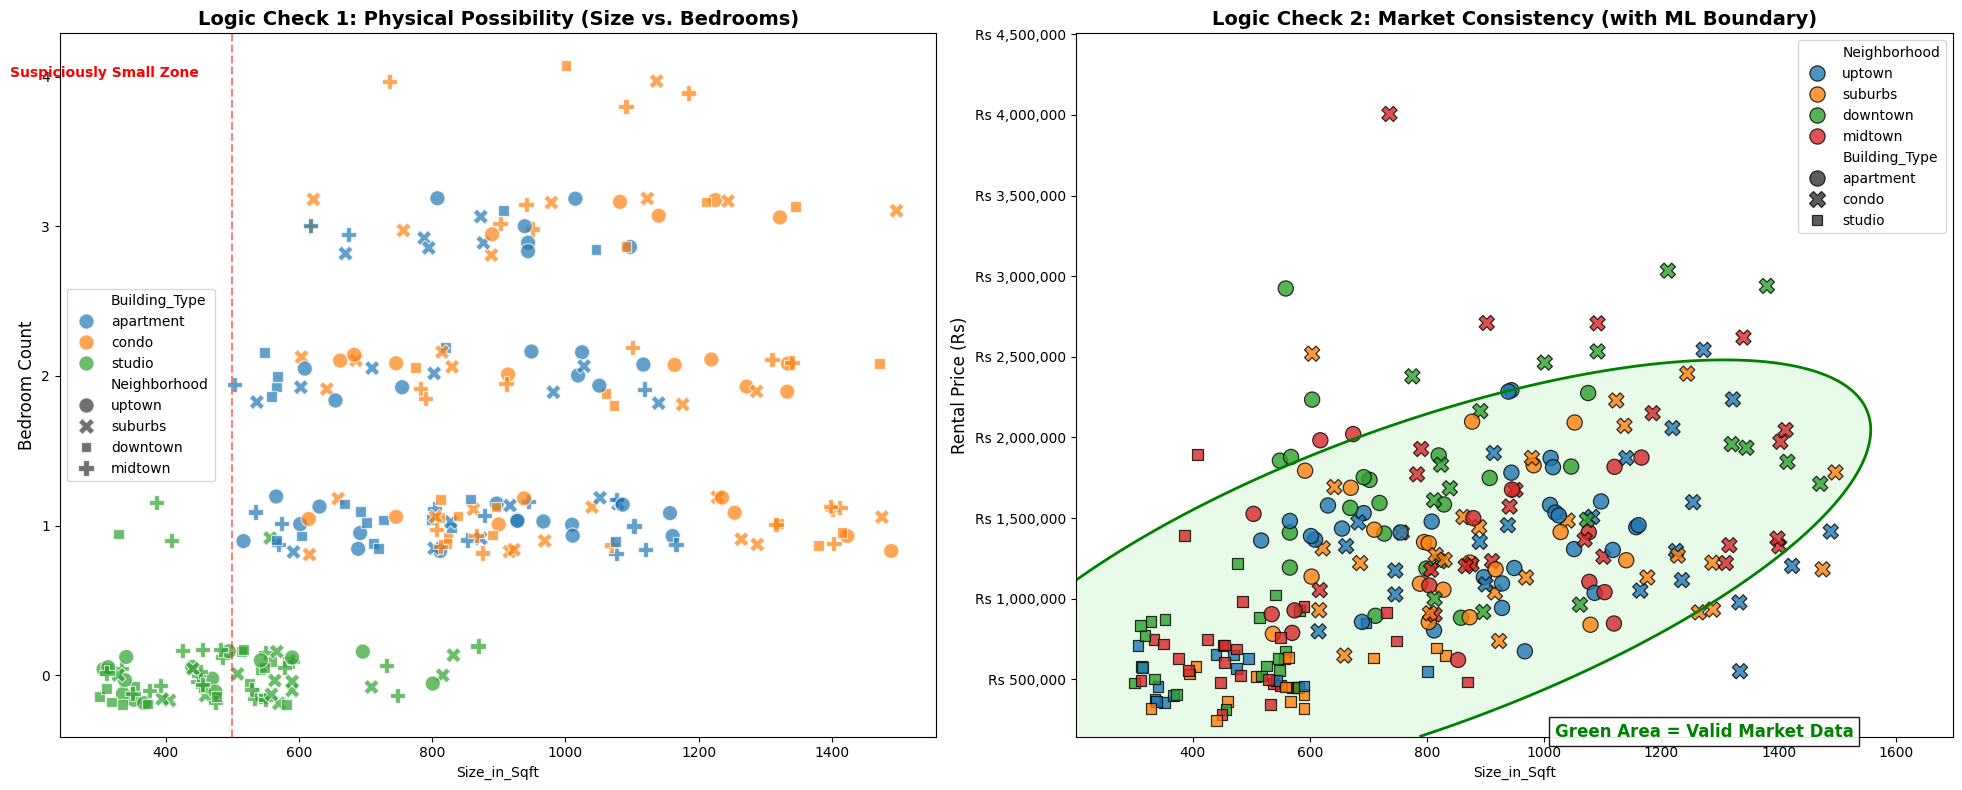

In [5]:
# 2. Convert to Rupees
df['Rental_Price_Rs'] = df['Rental_Price'] * 304.00

# 3. Create Jittered Bedrooms for Visualization
# We add random noise (-0.2 to +0.2) to the integer values to "spread" them
np.random.seed(42) # For consistent results
df['Bedrooms_Jittered'] = df['Bedrooms'] + np.random.uniform(-0.2, 0.2, size=len(df))

# 4. ML Setup: Define the "Normal" Area
X = df[['Size_in_Sqft', 'Rental_Price_Rs']].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Fit Elliptic Envelope (Outlier Detection)
model = EllipticEnvelope(contamination=0.1, random_state=42)
model.fit(X_scaled)

# 5. Generate the "Green Zone" Grid
x_min, x_max = df['Size_in_Sqft'].min() - 100, df['Size_in_Sqft'].max() + 200
y_min, y_max = df['Rental_Price_Rs'].min() - 100000, df['Rental_Price_Rs'].max() + 500000
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# Predict on the grid
X_grid = np.c_[xx.ravel(), yy.ravel()]
X_grid_scaled = scaler.transform(X_grid)
Z = model.decision_function(X_grid_scaled)
Z = Z.reshape(xx.shape)

# 6. Plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- GRAPH 1: Physical Logic (Size vs. Bedrooms) WITH JITTER ---
sns.scatterplot(
    data=df, 
    x='Size_in_Sqft', 
    y='Bedrooms_Jittered', # <--- USING THE JITTERED COLUMN HERE
    hue='Building_Type', 
    style='Neighborhood', 
    s=120, 
    alpha=0.7, 
    ax=axes[0]
)
axes[0].set_title('Logic Check 1: Physical Possibility (Size vs. Bedrooms)', fontsize=14, weight='bold')
axes[0].axvline(500, color='red', linestyle='--', alpha=0.5) 
axes[0].text(450, df['Bedrooms'].max(), "Suspiciously Small Zone", color='red', ha='right', weight='bold')
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axes[0].set_ylabel("Bedroom Count", fontsize=12)

# --- GRAPH 2: Price Logic (Price vs. Size) WITH ML BOUNDARY ---
# A. Draw the "Green Zone"
axes[1].contourf(xx, yy, Z, levels=[0, Z.max()], colors=['#90EE90'], alpha=0.2) # Light Green Area
axes[1].contour(xx, yy, Z, levels=[0], linewidths=2, colors='green') # Dark Green Border

# B. Draw the Scatter Points
sns.scatterplot(
    data=df, 
    x='Size_in_Sqft', 
    y='Rental_Price_Rs', 
    hue='Neighborhood', 
    style='Building_Type', 
    s=120, 
    alpha=0.8,
    edgecolor='black',
    ax=axes[1]
)

# Formatting Graph 2
axes[1].set_title('Logic Check 2: Market Consistency (with ML Boundary)', fontsize=14, weight='bold')
axes[1].yaxis.set_major_formatter(ticker.StrMethodFormatter('Rs {x:,.0f}')) 
axes[1].set_ylabel("Rental Price (Rs)", fontsize=12)
axes[1].text(x_max*0.6, y_min, "Green Area = Valid Market Data", color='green', weight='bold', fontsize=12, bbox=dict(facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

--- DATA CLEANING REPORT ---
1. Original Dataset Size: 250 rows
2. Dropped by Machine Learning (Statistical Anomalies): 25
3. Dropped by Logic Rules (Physically Impossible): 0
4. Total Rows Deleted (Combined): 25
5. Final Clean Dataset Size: 225 rows

--- Logic Errors Caught (Examples) ---
None found.


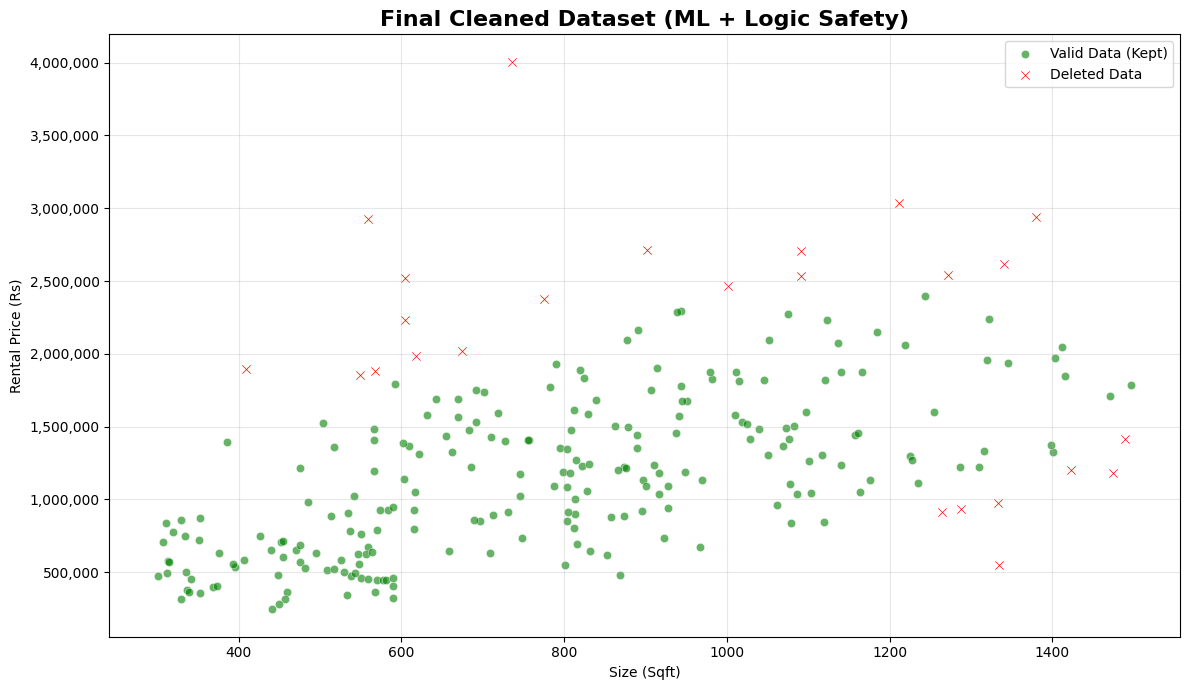

In [6]:
# 2. Convert to Rupees
df['Rental_Price_Rs'] = df['Rental_Price'] * 304.00

# --- STEP 1: The Green Circle (Machine Learning) ---
X = df[['Size_in_Sqft', 'Rental_Price_Rs']].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the Green Circle (Contamination 0.1 = Remove worst 10%)
model = EllipticEnvelope(contamination=0.1, random_state=42)
model.fit(X_scaled)
ml_outliers = model.predict(X_scaled) == -1 # True if outlier

# --- STEP 2: The "Sanity Check" (Logic) ---
# Rule A: Studios cannot have more than 1 Bedroom
mask_fake_studio = (df['Building_Type'] == 'studio') & (df['Bedrooms'] > 1)

# Rule B: Humans can't live in < 50 sqft per person (Cramped)
mask_impossible_size = (df['Size_in_Sqft'] / df['Bedrooms'].replace(0, 1)) < 50

# Combine Logic Masks
logic_outliers = mask_fake_studio | mask_impossible_size

# --- STEP 3: Combine Both ---
# We delete a row if ML hates it OR if Logic hates it
final_drop_mask = ml_outliers | logic_outliers
df_clean = df[~final_drop_mask].copy()

# Save the clean data for future use
df_clean.to_csv('df_final_clean.csv', index=False)

# --- REPORT GENERATION ---
print("--- DATA CLEANING REPORT ---")
print(f"1. Original Dataset Size: {len(df)} rows")
print(f"2. Dropped by Machine Learning (Statistical Anomalies): {sum(ml_outliers)}")
print(f"3. Dropped by Logic Rules (Physically Impossible): {sum(logic_outliers)}")
print(f"4. Total Rows Deleted (Combined): {sum(final_drop_mask)}")
print(f"5. Final Clean Dataset Size: {len(df_clean)} rows")

# Check what kind of logic errors were caught
print("\n--- Logic Errors Caught (Examples) ---")
if sum(logic_outliers) > 0:
    print(df.loc[logic_outliers, ['Building_Type', 'Bedrooms', 'Size_in_Sqft']].head().to_string())
else:
    print("None found.")

# --- VISUALIZATION ---
plt.figure(figsize=(12, 7))
# Plot Valid Data
sns.scatterplot(data=df_clean, x='Size_in_Sqft', y='Rental_Price_Rs', color='green', alpha=0.6, label='Valid Data (Kept)')
# Plot Dropped Data
df_dropped = df[final_drop_mask]
sns.scatterplot(data=df_dropped, x='Size_in_Sqft', y='Rental_Price_Rs', color='red', marker='x', label='Deleted Data')

plt.title('Final Cleaned Dataset (ML + Logic Safety)', fontsize=16, weight='bold')
plt.xlabel('Size (Sqft)')
plt.ylabel('Rental Price (Rs)')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('final_cleaning_report.png')
plt.show()

In [7]:
df_clean

Apartment_ID  Size_in_Sqft  Bedrooms  Bathrooms  \
0               1           692         1          2   
1               2           622         3          1   
2               3           559         0          1   
3               4           307         0          1   
4               5          1097         3          2   
..            ...           ...       ...        ...   
247           246           482         0          1   
248           247           807         1          1   
249           248          1235         1          2   
250           249          1052         1          2   
251           250           683         2          1   

     Distance_to_City_Center_KM Neighborhood    Furnished Building_Type  \
0                          2.07       uptown    furnished     apartment   
1                         10.85      suburbs  unfurnished         condo   
2                         10.55     downtown    furnished        studio   
3                          7.37       uptown    furnished        studio   
4                          7.41       uptown  unfurnished     apartment   
..                          ...          ...          ...           ...   
247                        7.19      midtown    furnished        studio   
248                        4.48      midtown    furnished         condo   
249                        7.64       uptown    furnished         condo   
250                        1.03      suburbs  unfurnished     apartment   
251                       10.52       uptown    furnished         condo   

     Rental_Price  Rental_Price_Rs  Bedrooms_Jittered  
0     5035.497680     1.530791e+06           0.949816  
1     4316.686202     1.312273e+06           3.180286  
2     2211.047997     6.721586e+05           0.092798  
3     2330.542651     7.084850e+05           0.039463  
4     5272.940908     1.602974e+06           2.862407  
..            ...              ...                ...  
247   1729.501548     5.257685e+05           0.171327  
248   3878.499944     1.179064e+06           0.971274  
249   3668.000968     1.115072e+06           1.186662  
250   6883.107093     2.092465e+06           1.185448  
251   4846.892203     1.473455e+06           2.141204  

[225 rows x 11 columns]

C:\Users\laksh\AppData\Local\Temp\ipykernel_25824\776878611.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats_str = stats_str.applymap(lambda x: f"{x:.2f}")


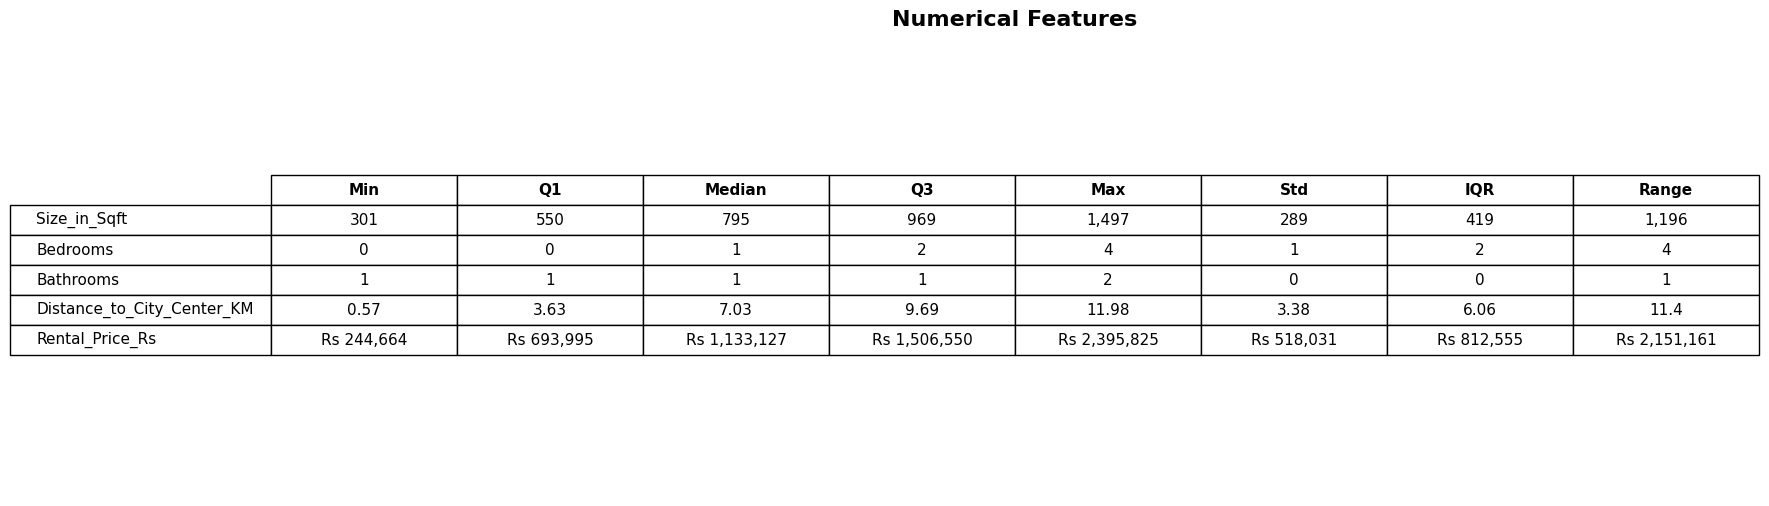

In [7]:
numerical_df = df_clean.select_dtypes(include=[np.number]).drop(['Apartment_ID', 'Rental_Price', 'Bedrooms_Jittered'], axis=1, errors='ignore')

stats = numerical_df.describe().T
stats = stats[['min', '25%', '50%', '75%', 'max', 'std']]
stats.rename(columns={'50%': 'Median', '25%': 'Q1', '75%': 'Q3', 'min': 'Min', 'max': 'Max', 'std': 'Std'}, inplace=True)
stats['IQR'] = stats['Q3'] - stats['Q1']
stats['Range'] = stats['Max'] - stats['Min']

# --- 3. Format Data for Display (Solves the "Unknown format code" error) ---
stats_str = stats.copy()

# Default format (2 decimals)
stats_str = stats_str.applymap(lambda x: f"{x:.2f}")

# Custom Format: Range (1 decimal)
stats_str['Range'] = stats['Range'].apply(lambda x: f"{x:.1f}")

# Custom Format: Integer Rows (Bedrooms/Bathrooms)
for row in ['Bedrooms', 'Bathrooms']:
    if row in stats_str.index:
        stats_str.loc[row] = stats.loc[row].apply(lambda x: f"{x:.0f}")

# Custom Format: Currency
if 'Rental_Price_Rs' in stats_str.index:
    stats_str.loc['Rental_Price_Rs'] = stats.loc['Rental_Price_Rs'].apply(lambda x: f"Rs {x:,.0f}")

# Custom Format: Size (No decimals)
if 'Size_in_Sqft' in stats_str.index:
    stats_str.loc['Size_in_Sqft'] = stats.loc['Size_in_Sqft'].apply(lambda x: f"{x:,.0f}")

# --- 4. Plot Table using Matplotlib ---
fig, ax = plt.subplots(figsize=(16, 6))
ax.axis('off')

# Create the table
table = ax.table(
    cellText=stats_str.values,
    rowLabels=stats_str.index,
    colLabels=stats_str.columns,
    cellLoc='center',
    loc='center'
)

# Styling
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8) # Adjust row height

# Bold the headers
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')

plt.title("Numerical Features", weight='bold', fontsize=16)
plt.show()

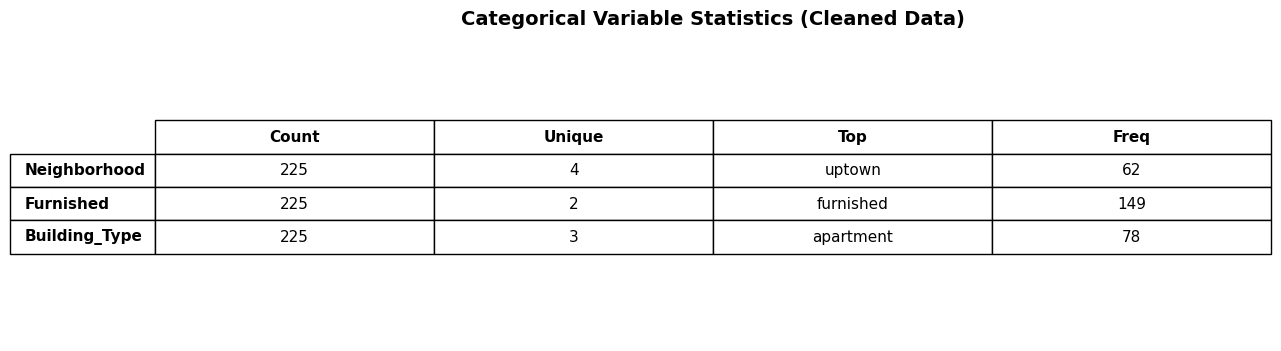

In [8]:
# 2. Select Categorical Data
categorical_df = df_clean.select_dtypes(include=['object'])
stats = categorical_df.describe().T
stats = stats[['count', 'unique', 'top', 'freq']]
stats.rename(columns={'count': 'Count', 'unique':'Unique', 'top':'Top', 'freq':'Freq'}, inplace=True)

# 3. Plot with Matplotlib
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')

# Create the table
table = ax.table(
    cellText=stats.values,
    rowLabels=stats.index,
    colLabels=stats.columns,
    cellLoc='center',
    loc='center'
)

# Styling to match your requirements
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2.0) # Adjust row height

# Bold the headers and Index
for (row, col), cell in table.get_celld().items():
    if row == 0 or col == -1:
        cell.set_text_props(weight='bold')

plt.title("Categorical Variable Statistics (Cleaned Data)", weight='bold', fontsize=14)
plt.show()


In [10]:
df_clean

Apartment_ID  Size_in_Sqft  Bedrooms  Bathrooms  \
0               1           692         1          2   
1               2           622         3          1   
2               3           559         0          1   
3               4           307         0          1   
4               5          1097         3          2   
..            ...           ...       ...        ...   
247           246           482         0          1   
248           247           807         1          1   
249           248          1235         1          2   
250           249          1052         1          2   
251           250           683         2          1   

     Distance_to_City_Center_KM Neighborhood    Furnished Building_Type  \
0                          2.07       uptown    furnished     apartment   
1                         10.85      suburbs  unfurnished         condo   
2                         10.55     downtown    furnished        studio   
3                          7.37       uptown    furnished        studio   
4                          7.41       uptown  unfurnished     apartment   
..                          ...          ...          ...           ...   
247                        7.19      midtown    furnished        studio   
248                        4.48      midtown    furnished         condo   
249                        7.64       uptown    furnished         condo   
250                        1.03      suburbs  unfurnished     apartment   
251                       10.52       uptown    furnished         condo   

     Rental_Price  Rental_Price_Rs  Bedrooms_Jittered  
0     5035.497680     1.530791e+06           0.949816  
1     4316.686202     1.312273e+06           3.180286  
2     2211.047997     6.721586e+05           0.092798  
3     2330.542651     7.084850e+05           0.039463  
4     5272.940908     1.602974e+06           2.862407  
..            ...              ...                ...  
247   1729.501548     5.257685e+05           0.171327  
248   3878.499944     1.179064e+06           0.971274  
249   3668.000968     1.115072e+06           1.186662  
250   6883.107093     2.092465e+06           1.185448  
251   4846.892203     1.473455e+06           2.141204  

[225 rows x 11 columns]

<h1 style="color:pink">2. Data Visualization</h1>

<h2>a.</h2>

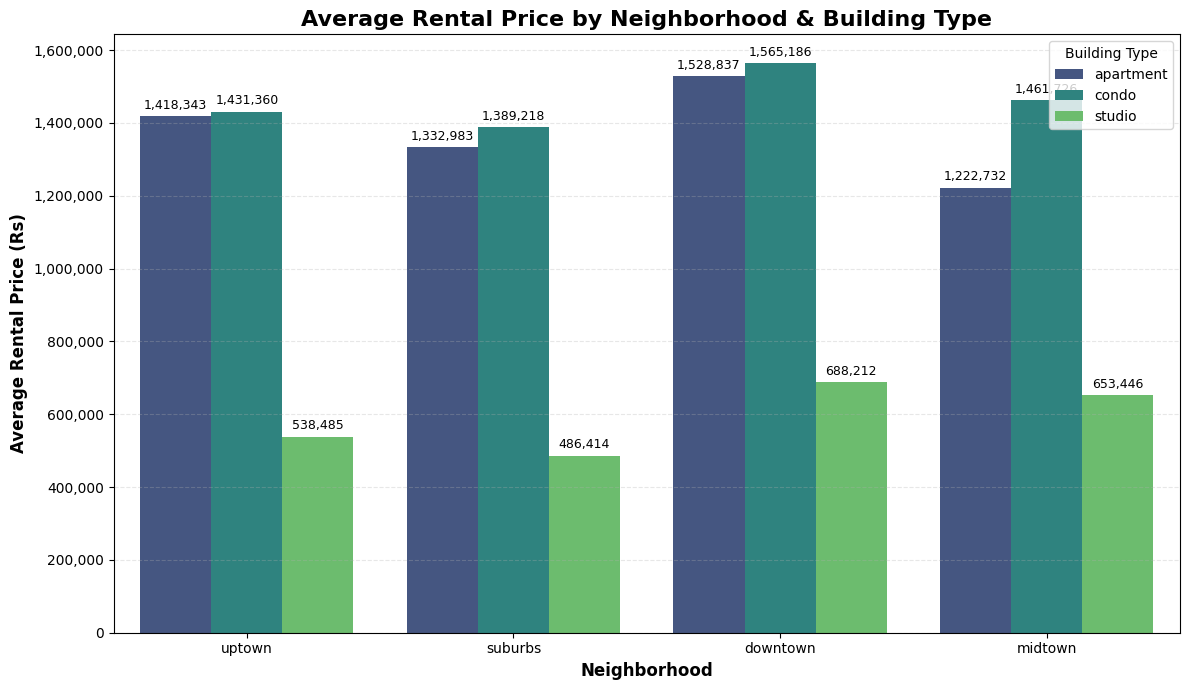

In [9]:
plt.figure(figsize=(12, 7))

# Create the plot
ax = sns.barplot(data=df_clean, x='Neighborhood', y='Rental_Price_Rs', hue='Building_Type', palette='viridis', errorbar=None)

# --- THE ADDITION: Print Values on Bars ---
for container in ax.containers:
    # fmt='{:,.0f}' puts commas in the number (e.g. 1,200,000)
    ax.bar_label(container, fmt='{:,.0f}', fontsize=9, padding=3)

# Formatting
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Average Rental Price by Neighborhood & Building Type', fontsize=16, weight='bold')
plt.xlabel('Neighborhood', fontsize=12, weight='bold')
plt.ylabel('Average Rental Price (Rs)', fontsize=12, weight='bold')
plt.legend(title='Building Type', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

plt.show()

<h1>b.</h>

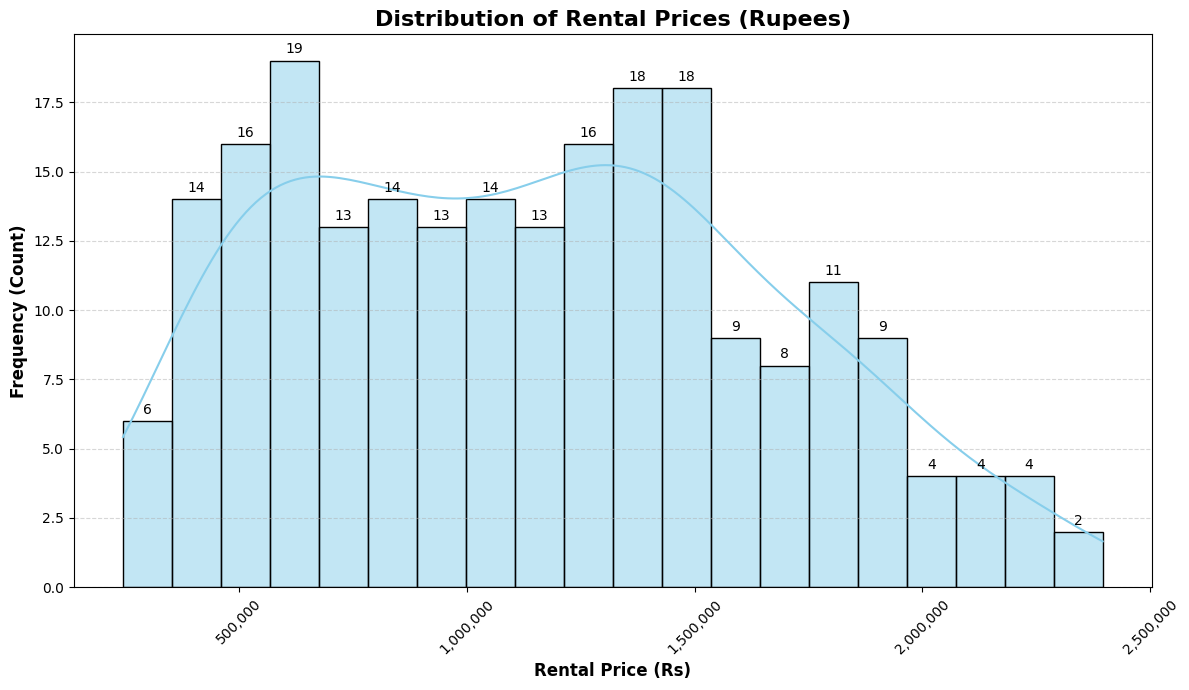

In [10]:
# Create the Histogram
plt.figure(figsize=(12, 7))

# We assign it to 'ax' so we can manipulate the bars later
ax = sns.histplot(data=df_clean, x='Rental_Price_Rs', bins=20, kde=True, color='skyblue', edgecolor='black')

# --- THE ADDITION: Print Counts on Top of Bars ---
# histplot puts the bars in ax.containers[0]
# We loop through them and add the label
for container in ax.containers:
    # We use explicit formatting to show just the integer count
    ax.bar_label(container, fmt='%.0f', fontsize=10, padding=3)

# Add Labels and Title
plt.title('Distribution of Rental Prices (Rupees)', fontsize=16, weight='bold')
plt.xlabel('Rental Price (Rs)', fontsize=12, weight='bold')
plt.ylabel('Frequency (Count)', fontsize=12, weight='bold')

# FIX: Format X-Axis to use Commas (e.g., 1,000,000) instead of Scientific Notation (1e6)
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Styling
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

<h2>c.</h2>

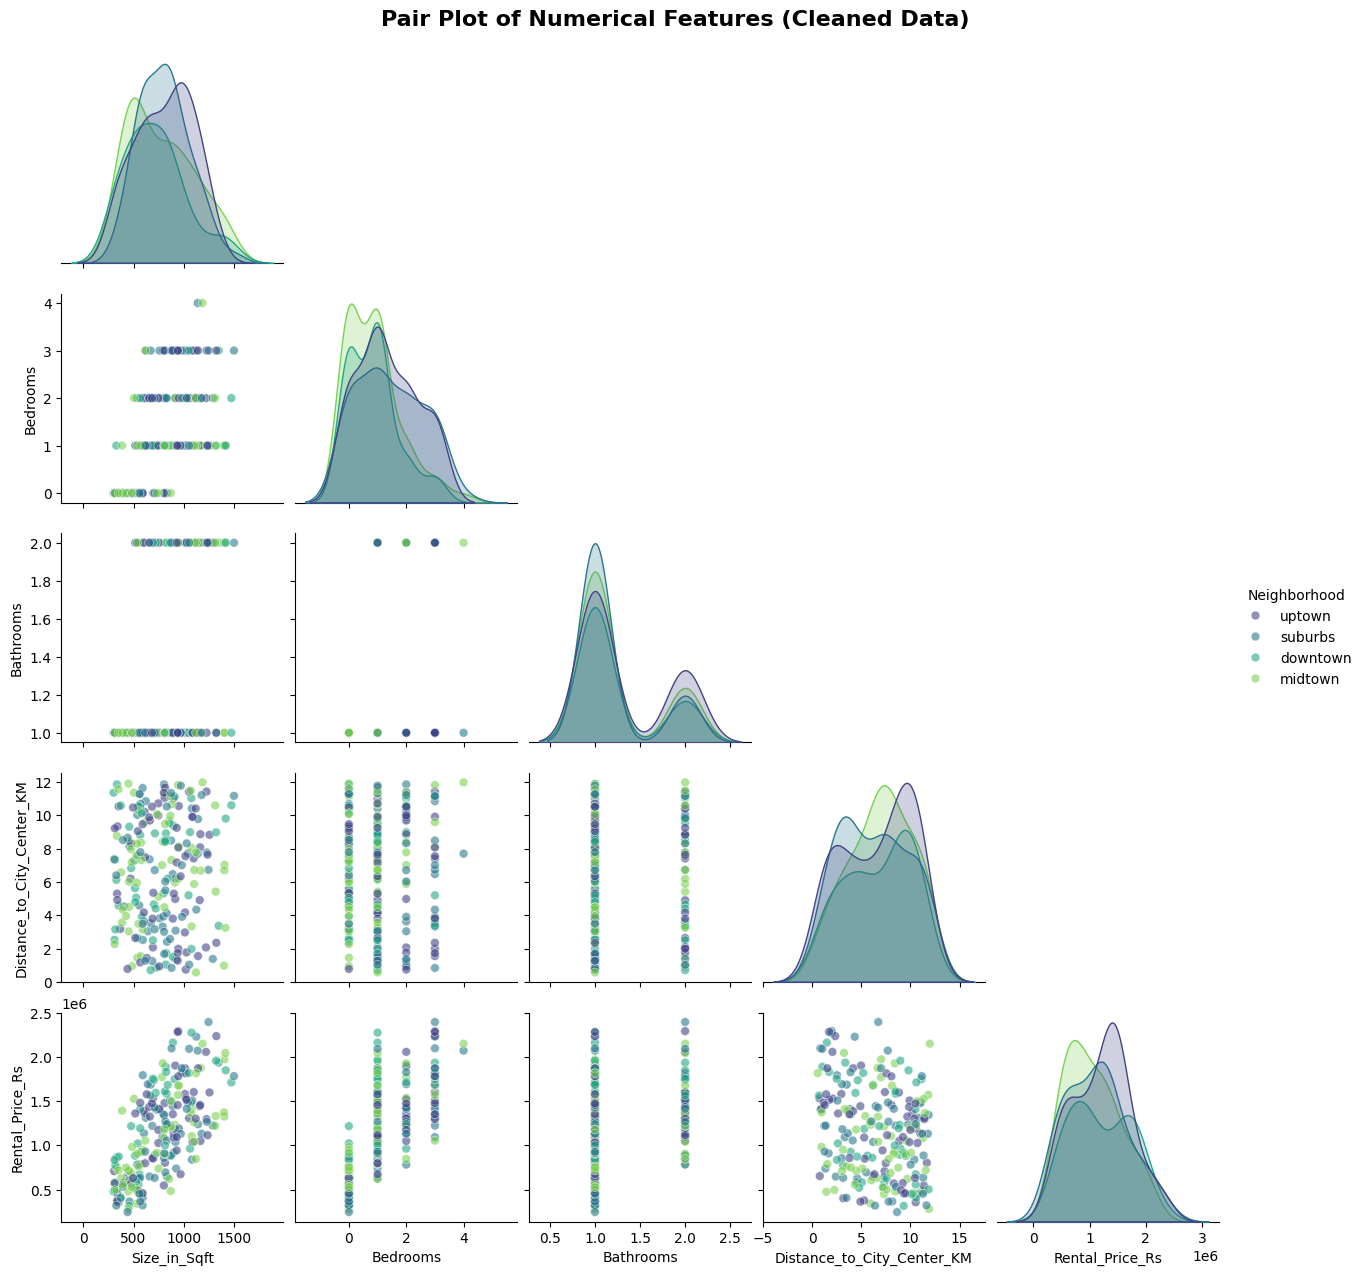

In [11]:
# Define features (Using the clean, Rupee-based price)
numerical_features = [
    'Size_in_Sqft', 
    'Bedrooms', 
    'Bathrooms', 
    'Distance_to_City_Center_KM', 
    'Rental_Price_Rs'
]

# Create the Pair Plot
sns.pairplot(
    df_clean[numerical_features + ['Neighborhood']], 
    hue='Neighborhood',
    palette='viridis',
    diag_kind='kde',   # Density plot on diagonal
    corner=True,       # KEY CHANGE: Removes upper triangle for clarity
    height=2.5,
    plot_kws={'alpha': 0.6, 's': 40} # Transparency helps with overlapping dots
)

plt.suptitle('Pair Plot of Numerical Features (Cleaned Data)', y=1.02, fontsize=16, weight='bold')
plt.show()

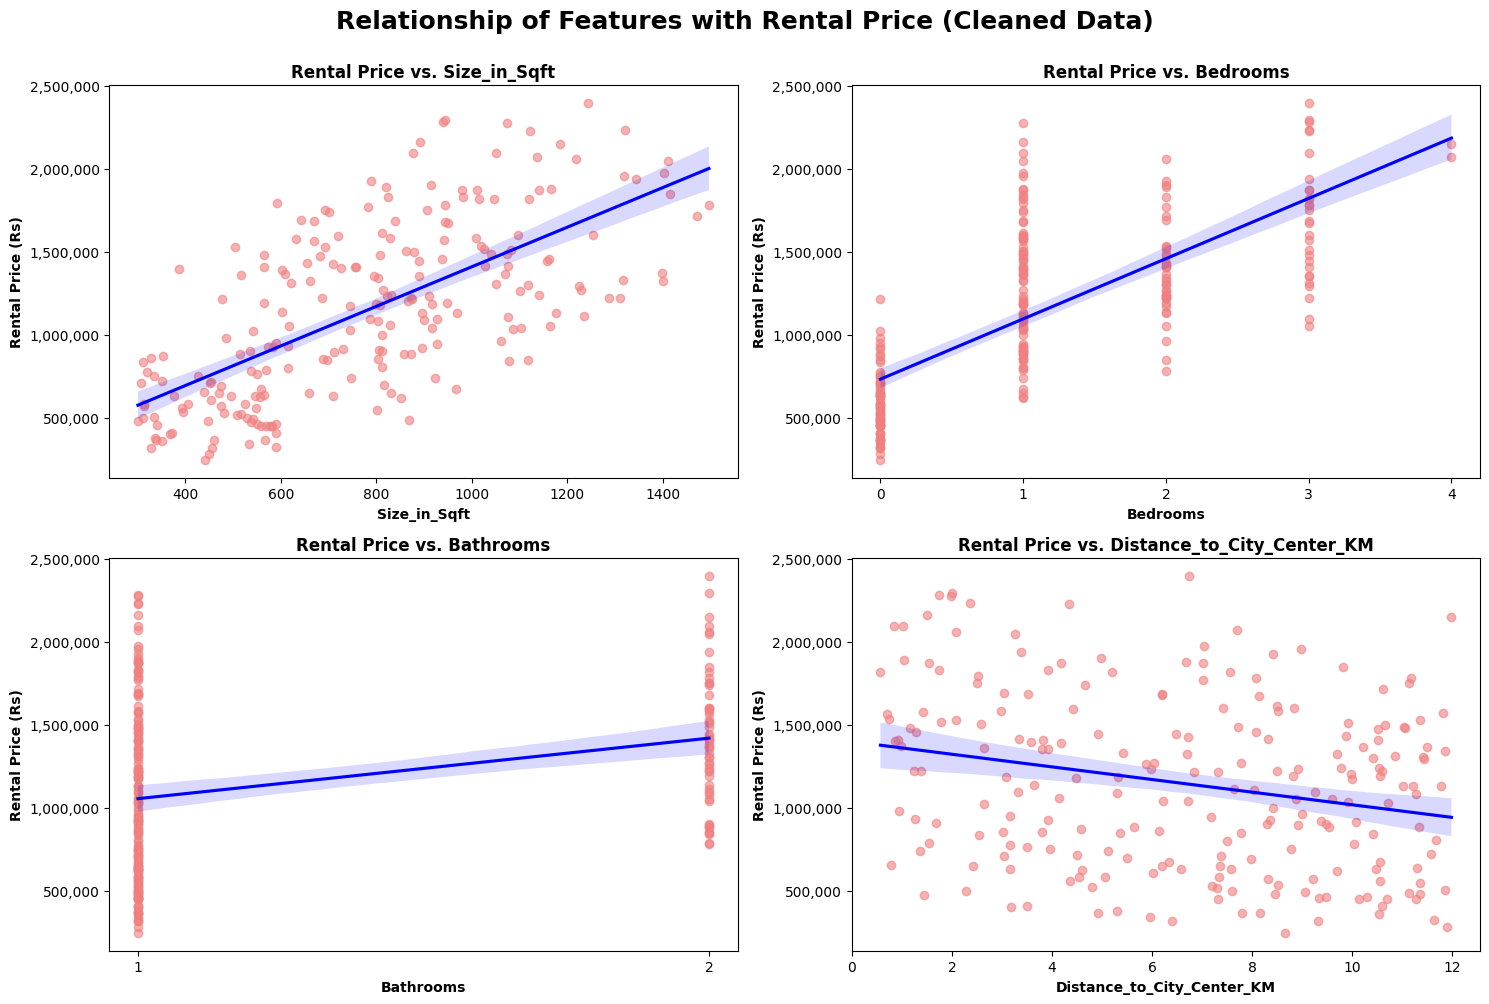

In [12]:
# 2. Create the Multi-Panel Plot
numerical_features = ['Size_in_Sqft', 'Bedrooms', 'Bathrooms', 'Distance_to_City_Center_KM']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.regplot(
        data=df_clean,
        x=feature,
        y='Rental_Price_Rs',
        ax=axes[i],
        color='lightcoral',
        scatter_kws={'alpha': 0.6}, # Semi-transparent dots
        line_kws={'color': 'blue'}  # Blue trend line
    )
    
    # Titles and Labels
    axes[i].set_title(f'Rental Price vs. {feature}', fontsize=12, weight='bold')
    axes[i].set_xlabel(feature, weight='bold')
    axes[i].set_ylabel('Rental Price (Rs)', weight='bold')
    
    # FIX: Format Y-Axis (Rs 1,000,000) - No Scientific Notation
    axes[i].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    # FIX: Ensure Bed/Bath counts are integers (0, 1, 2) not (1.0, 1.5)
    if feature in ['Bedrooms', 'Bathrooms']:
        axes[i].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.suptitle('Relationship of Features with Rental Price (Cleaned Data)', fontsize=18, y=1.0, weight='bold')
plt.tight_layout()
plt.show()

<h2>d.</h2>

In [13]:
#boxplot comparison of the distribution of Rental_Price furnished vs. unfurnished apartments
df_apartment = df_clean[df_clean['Building_Type'] == 'apartment']
df_apartment


Apartment_ID  Size_in_Sqft  Bedrooms  Bathrooms  \
0               1           692         1          2   
4               5          1097         3          2   
6               7           592         1          1   
7               8           897         1          1   
8               9           799         1          1   
..            ...           ...       ...        ...   
233           232           939         3          1   
234           233           928         1          2   
235           234          1103         1          2   
238           237          1119         2          2   
250           249          1052         1          2   

     Distance_to_City_Center_KM Neighborhood    Furnished Building_Type  \
0                          2.07       uptown    furnished     apartment   
4                          7.41       uptown  unfurnished     apartment   
6                          2.52      suburbs  unfurnished     apartment   
7                         11.02       uptown  unfurnished     apartment   
8                          5.32     downtown  unfurnished     apartment   
..                          ...          ...          ...           ...   
233                        1.73       uptown  unfurnished     apartment   
234                        9.25       uptown  unfurnished     apartment   
235                        6.72      midtown  unfurnished     apartment   
238                        7.78      midtown    furnished     apartment   
250                        1.03      suburbs  unfurnished     apartment   

     Rental_Price  Rental_Price_Rs  Bedrooms_Jittered  
0     5035.497680     1.530791e+06           0.949816  
4     5272.940908     1.602974e+06           2.862407  
6     5901.029902     1.793913e+06           0.823233  
7     3727.392455     1.133127e+06           1.146470  
8     3904.539655     1.186980e+06           1.040446  
..            ...              ...                ...  
233   7514.199952     2.284317e+06           3.001055  
234   3599.883656     1.094365e+06           1.030762  
235   3422.884419     1.040557e+06           0.997007  
238   2782.907171     8.460038e+05           1.912309  
250   6883.107093     2.092465e+06           1.185448  

[78 rows x 11 columns]

Consider the runs scored by a cricket team in 12 matches: 100, 120, 110, 150, 110, 140, 130, 170, 120, 220, 140, 110

**Step 1: Arrange Data in Ascending Order**
* 100, 110, 110, 110, 120, 120, 130, 140, 140, 150, 170, 220

**Step 2: Find Quartiles and Median**
* $\textbf{Median} (Q_{2}) = \frac{120+130}{2} = 125$
* $Q_{1} = \textbf{Median of first 6 values} = \frac{110+110}{2} = 110$
* $Q_{3} = \textbf{Median of last 6 values} = \frac{140+150}{2} = 145$

**Step 3: Compute IQR**
* $IQR = 145 - 110 = 35$

**Step 4: Calculate Limits**
* $\text{Lower Limit} = 110 - 1.5 \times 35 = 57.5$
* $\text{Upper Limit} = 145 + 1.5 \times 35 = 197.5$

**Step 5: Identify Min, Max and Outliers**
* Minimum (within limit) = 100
* Maximum (within limit) = 170
* Outlier = 220

<img src="419171618.webp" />

Summary Statistics Table (Apartments Only):
Furnished    furnished  unfurnished
count        24.000000    54.000000
mean       4237.839979  4691.063829
std        1327.419232  1264.953668
min        2215.896727  2039.851098
25%        2954.851254  3777.253992
50%        4247.466309  4708.269920
75%        5077.118274  5454.822449
max        7542.763217  7514.199952


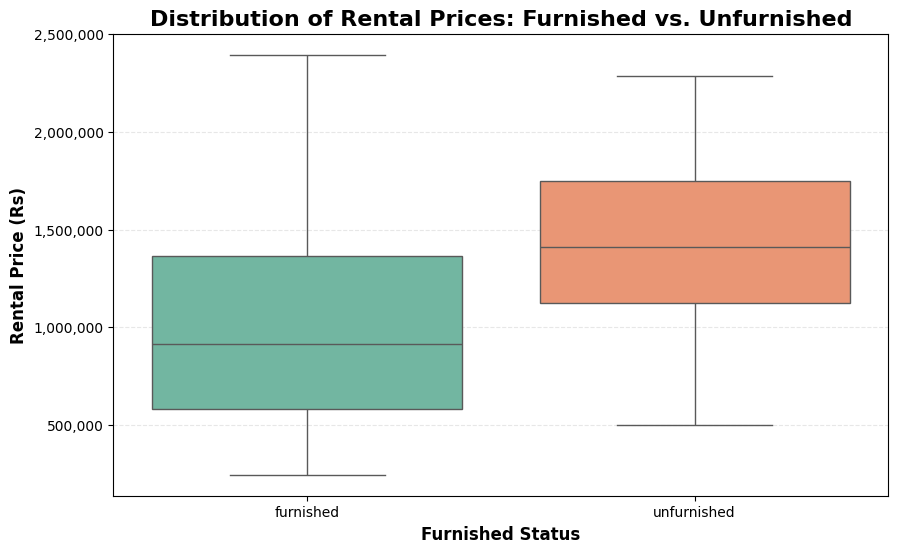

In [14]:
# 2. Calculate summary statistics for Rental_Price grouped by Furnished status
summary_table = df_apartment.groupby('Furnished')['Rental_Price'].describe().T

print("Summary Statistics Table (Apartments Only):")
print(summary_table)

# Create the Boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=df_clean,
    x='Furnished',
    y='Rental_Price_Rs',
    palette='Set2',
    hue='Furnished'
)

# Format the Y-Axis to show Rs 1,000,000 (Readable)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.title('Distribution of Rental Prices: Furnished vs. Unfurnished', fontsize=16, weight='bold')
plt.ylabel('Rental Price (Rs)', fontsize=12, weight='bold')
plt.xlabel('Furnished Status', fontsize=12, weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()


<h2>e.</h2>

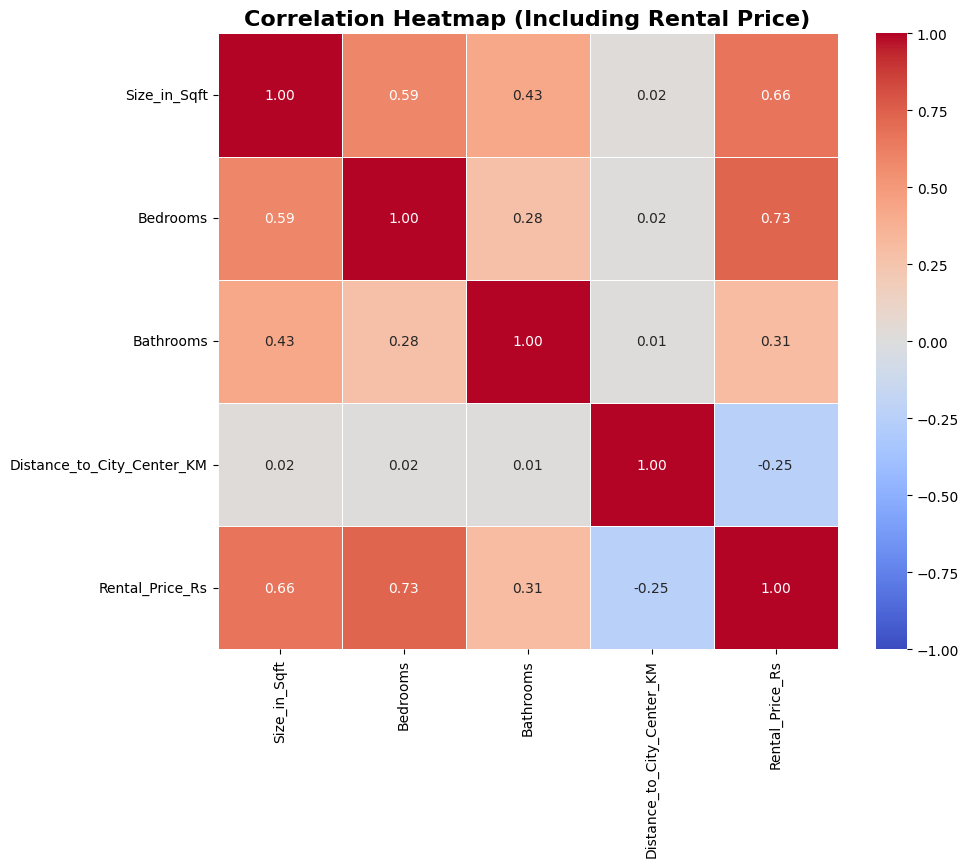

In [15]:
numerical_features = [
    'Size_in_Sqft', 
    'Bedrooms', 
    'Bathrooms', 
    'Distance_to_City_Center_KM', 
    'Rental_Price_Rs'  # <--- The most important one!
]

# 2. Calculate the Correlation Matrix
# This works on the clean dataframe we made earlier
corr_matrix = df_clean[numerical_features].corr()

# 3. Create the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True,       # Show the numbers (e.g., 0.85)
    cmap='coolwarm',  # Red = Hot (Strong Positive), Blue = Cold (Negative)
    fmt=".2f",        # 2 decimal places
    linewidths=0.5,   # White lines between boxes
    vmin=-1, vmax=1   # Scale from -1 to +1
)

plt.title('Correlation Heatmap (Including Rental Price)', fontsize=16, weight='bold')
plt.show()

<h1 style="color:pink">3. Explorative Data Analysis</h1>
<h2>A</h2>
<h3>a</h3>

--- Average Rental Price by Neighborhood (Rs) ---
  Neighborhood  Rental_Price_Rs
3       uptown     1.209043e+06
0     downtown     1.199064e+06
2      suburbs     1.121747e+06
1      midtown     1.055641e+06


C:\Users\laksh\AppData\Local\Temp\ipykernel_25824\1388621582.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


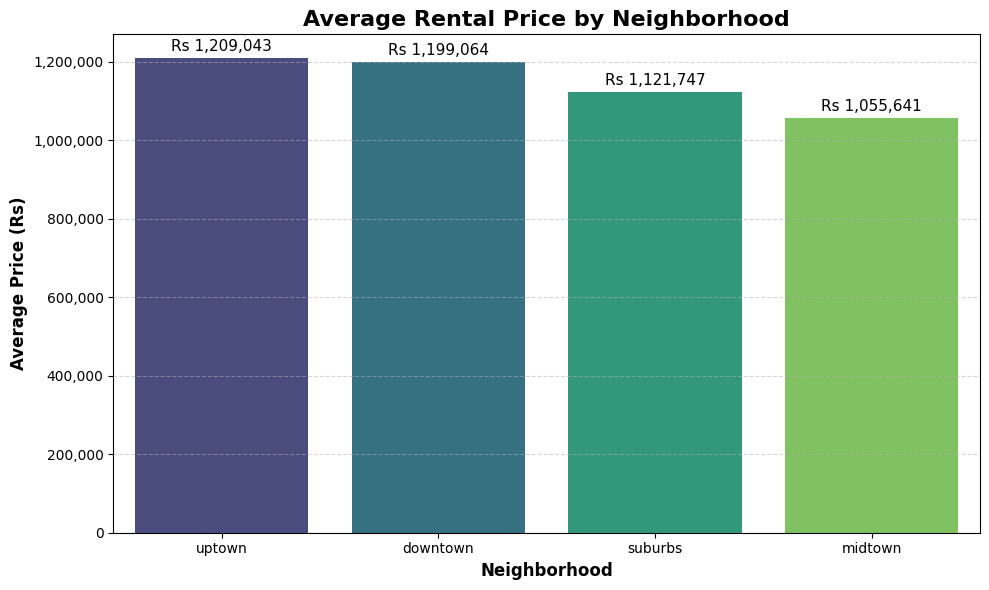

In [16]:
# 1. Calculate the Average Price per Neighborhood
# We group by neighborhood and calculate the mean of the Rupee column
avg_price_neighborhood = df_clean.groupby('Neighborhood')['Rental_Price_Rs'].mean().reset_index()

# Sort by price (High to Low) for better visualization
avg_price_neighborhood = avg_price_neighborhood.sort_values(by='Rental_Price_Rs', ascending=False)

print("--- Average Rental Price by Neighborhood (Rs) ---")
print(avg_price_neighborhood)

# 2. Create the Visualization (Bar Chart)
plt.figure(figsize=(10, 6))

# Define custom colors if you want, or use a palette like 'magma' or 'viridis'
ax = sns.barplot(
    data=avg_price_neighborhood,
    x='Neighborhood',
    y='Rental_Price_Rs',
    palette='viridis' # Color scheme
)

# 3. Add Labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='Rs {:,.0f}', fontsize=11, padding=3)

# 4. Formatting
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')) # Format Y-axis with commas
plt.title('Average Rental Price by Neighborhood', fontsize=16, weight='bold')
plt.xlabel('Neighborhood', fontsize=12, weight='bold')
plt.ylabel('Average Price (Rs)', fontsize=12, weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

<h3>b.</h3>

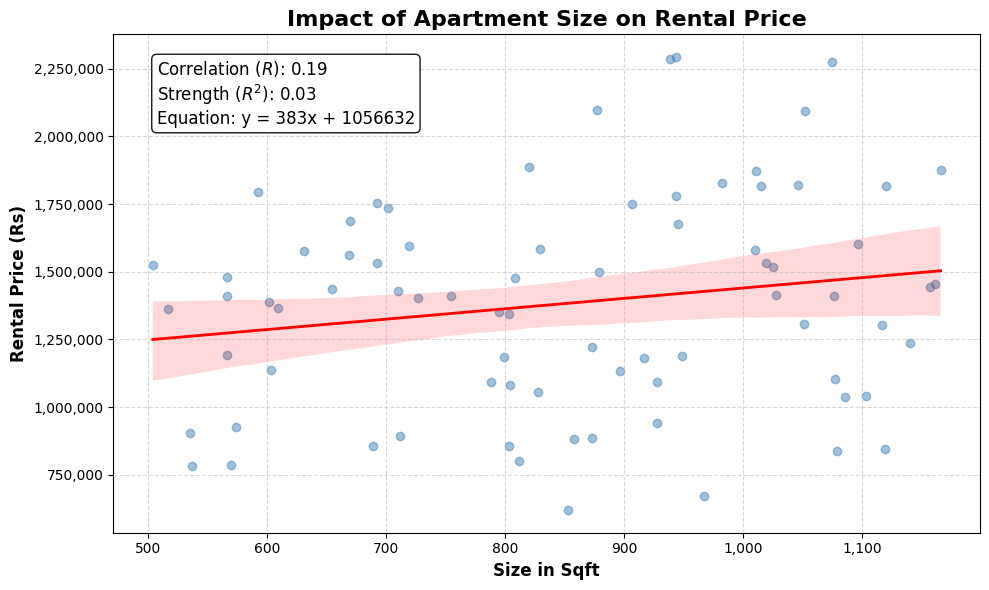

Insight: For every additional 1 sqft, the rent increases by approximately Rs 383.


In [19]:
# 1. Calculate the Regression Math (The "Slope")
slope, intercept, r_value, p_value, std_err = stats.linregress(df_apartment['Size_in_Sqft'], df_apartment['Rental_Price_Rs'])
r_squared = r_value ** 2

# 2. Create the Regression Plot
plt.figure(figsize=(10, 6))

# scatter_kws={'alpha':0.5} makes dots transparent so you can see density
# line_kws={'color':'red'} makes the regression line stand out
ax = sns.regplot(
    data=df_apartment,
    x='Size_in_Sqft',
    y='Rental_Price_Rs',
    scatter_kws={'alpha': 0.5, 'color': 'steelblue'},
    line_kws={'color': 'red', 'linewidth': 2}
)

# 3. Add the Math to the Chart (The Annotation)
text_str = f'Correlation ($R$): {r_value:.2f}\nStrength ($R^2$): {r_squared:.2f}\nEquation: y = {slope:.0f}x + {intercept:.0f}'
plt.text(
    0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12,
    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9)
)

# 4. Formatting
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')) # Rs 1,000,000
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')) # 1,000 sqft

plt.title('Impact of Apartment Size on Rental Price', fontsize=16, weight='bold')
plt.xlabel('Size in Sqft', fontsize=12, weight='bold')
plt.ylabel('Rental Price (Rs)', fontsize=12, weight='bold')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"Insight: For every additional 1 sqft, the rent increases by approximately Rs {slope:.0f}.")


<h3>c.</h3>

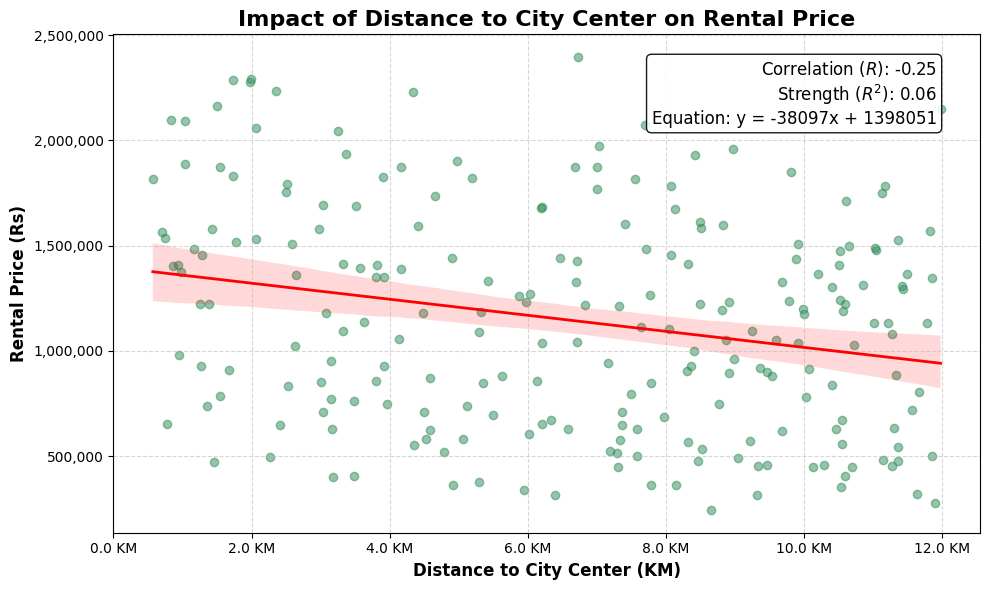

Insight: For every additional 1 KM you move away from the city, the rent DROPS by approximately Rs 38,097.


In [20]:
# 1. Calculate the Regression Math
# We expect a negative slope here (Price goes DOWN as Distance goes UP)
slope, intercept, r_value, p_value, std_err = stats.linregress(df_clean['Distance_to_City_Center_KM'], df_clean['Rental_Price_Rs'])
r_squared = r_value ** 2

# 2. Create the Plot
plt.figure(figsize=(10, 6))

# scatter_kws={'alpha':0.5} -> Transparent dots to show density
# line_kws={'color':'red'} -> The regression line
ax = sns.regplot(
    data=df_clean,
    x='Distance_to_City_Center_KM',
    y='Rental_Price_Rs',
    scatter_kws={'alpha': 0.5, 'color': 'seagreen'}, # Green color to distinguish from Size chart
    line_kws={'color': 'red', 'linewidth': 2}
)

# 3. Add the Math (Annotation)
text_str = f'Correlation ($R$): {r_value:.2f}\nStrength ($R^2$): {r_squared:.2f}\nEquation: y = {slope:.0f}x + {intercept:.0f}'
# Position text at top right
plt.text(
    0.95, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12,
    verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9)
)

# 4. Formatting
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')) # Rs 1,000,000
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f KM'))  # 5.0 KM

plt.title('Impact of Distance to City Center on Rental Price', fontsize=16, weight='bold')
plt.xlabel('Distance to City Center (KM)', fontsize=12, weight='bold')
plt.ylabel('Rental Price (Rs)', fontsize=12, weight='bold')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print the clear insight
print(f"Insight: For every additional 1 KM you move away from the city, the rent DROPS by approximately Rs {abs(slope):,.0f}.")

<h3>d.</h3>

--- Justification Table (Readable) ---
               Mean Price  Median Price
Furnished                              
furnished    Rs 1,288,303  Rs 1,291,230
unfurnished  Rs 1,426,083  Rs 1,431,314


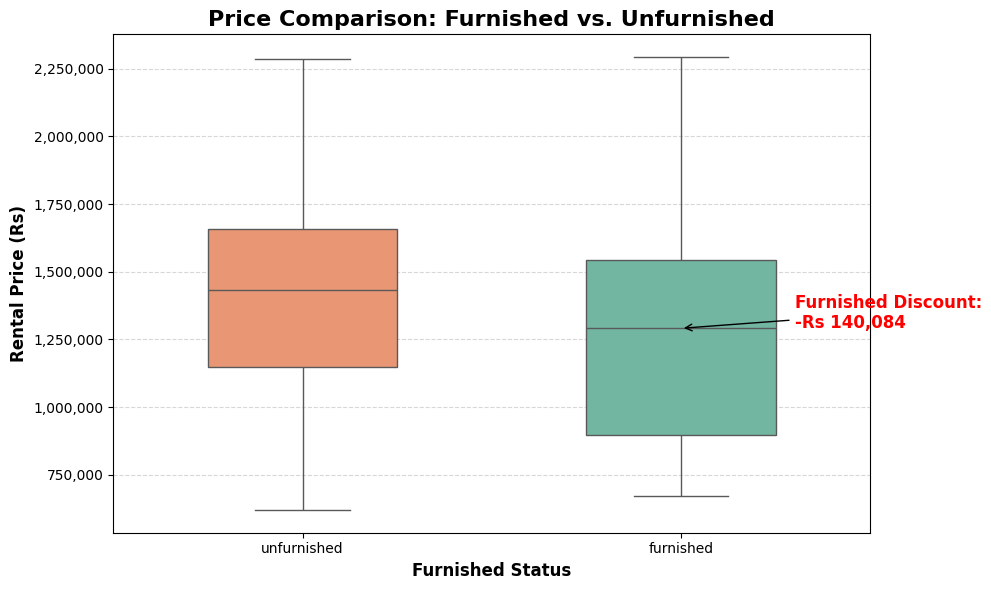

In [21]:
# 1. Prepare Data
order = ['unfurnished', 'furnished']

# 2. Calculate Stats & Format Table
summary = df_apartment.groupby('Furnished')['Rental_Price_Rs'].describe()[['mean', '50%']]
summary.columns = ['Mean Price', 'Median Price']

# Calculate the gap (Furnished - Unfurnished)
median_unfurnished = summary.loc['unfurnished', 'Median Price']
median_furnished = summary.loc['furnished', 'Median Price']
gap = median_furnished - median_unfurnished

# Format the table for display (No more e+06!)
summary_formatted = summary.map(lambda x: f"Rs {x:,.0f}")
print("--- Justification Table (Readable) ---")
print(summary_formatted)

# 3. Create Visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Boxplot
sns.boxplot(
    data=df_apartment,
    x='Furnished',
    y='Rental_Price_Rs',
    order=order,
    palette='Set2',
    hue='Furnished',
    legend=False,
    width=0.5
)

# 4. Add Dynamic Annotation (Handling the "Discount")
# Since gap is negative (approx -390k), we call it a "Discount"
text_label = f"Furnished Discount:\n-Rs {abs(gap):,.0f}" 
color = 'red' # Red because it's "less" value for the landlord (or discount for tenant)

plt.annotate(
    text_label, 
    xy=(1, median_furnished), 
    xytext=(1.3, median_furnished),
    arrowprops=dict(facecolor=color, arrowstyle='->'),
    fontsize=12, weight='bold', color=color
)

# 5. Formatting
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Price Comparison: Furnished vs. Unfurnished', fontsize=16, weight='bold')
plt.xlabel('Furnished Status', fontsize=12, weight='bold')
plt.ylabel('Rental Price (Rs)', fontsize=12, weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

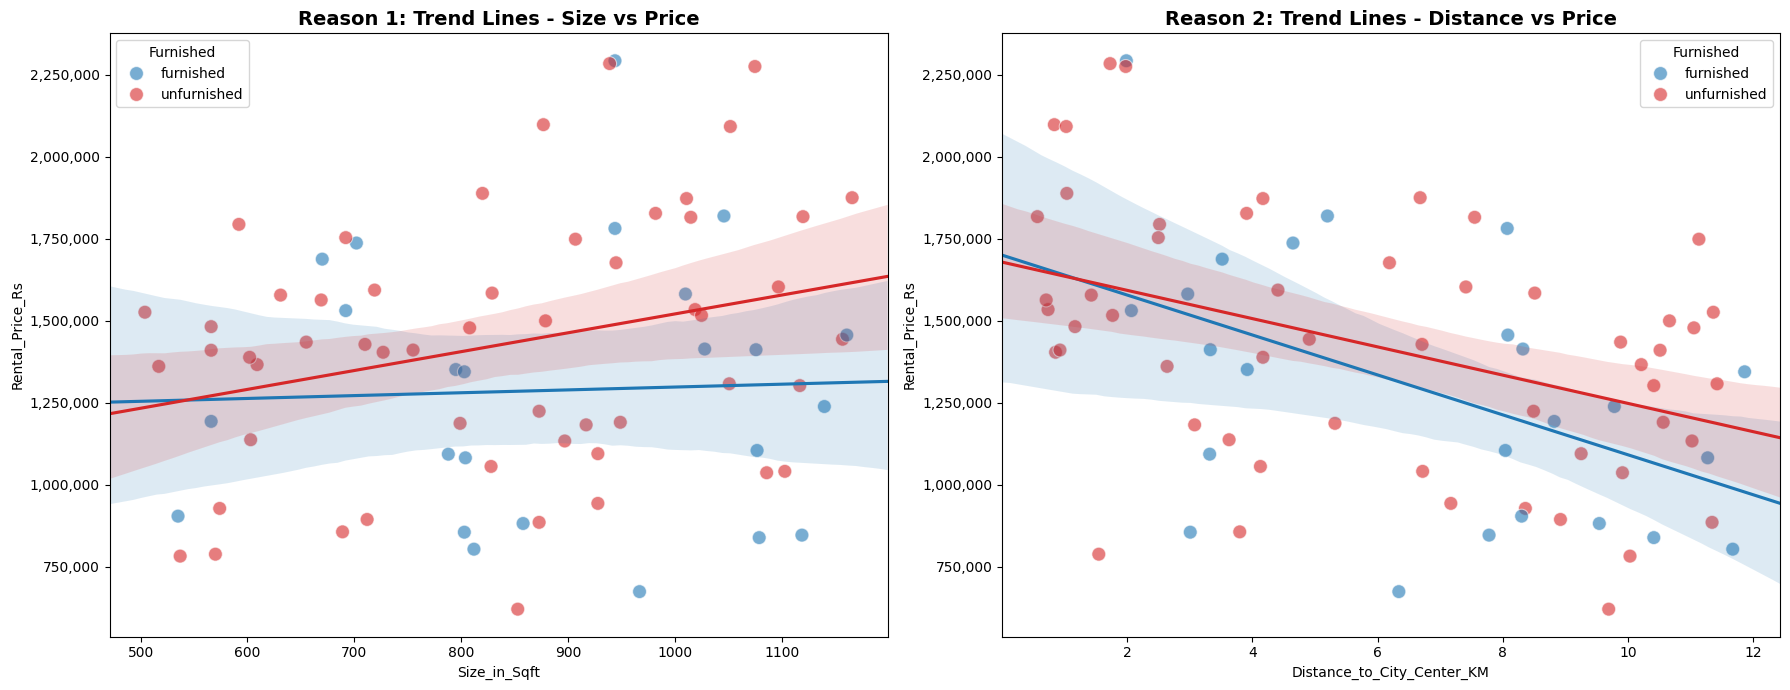

In [23]:
# Setup
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
colors = {'furnished': 'tab:blue', 'unfurnished': 'tab:red'} # specific colors to ensure matching

# --- PLOT 1: Price vs. Size ---
sns.scatterplot(
    data=df_apartment, 
    x='Size_in_Sqft', 
    y='Rental_Price_Rs', 
    hue='Furnished', 
    palette=colors,
    s=100, alpha=0.6, ax=axes[0]
)
# Add Trend Lines
for status, color in colors.items():
    sns.regplot(
        data=df_apartment[df_apartment['Furnished'] == status], 
        x='Size_in_Sqft', y='Rental_Price_Rs', 
        scatter=False, color=color, ax=axes[0], truncate=False
    )

axes[0].set_title('Reason 1: Trend Lines - Size vs Price', fontsize=14, weight='bold')
axes[0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# --- PLOT 2: Price vs. Distance ---
sns.scatterplot(
    data=df_apartment, 
    x='Distance_to_City_Center_KM', 
    y='Rental_Price_Rs', 
    hue='Furnished', 
    palette=colors,
    s=100, alpha=0.6, ax=axes[1]
)
# Add Trend Lines
for status, color in colors.items():
    sns.regplot(
        data=df_apartment[df_apartment['Furnished'] == status], 
        x='Distance_to_City_Center_KM', y='Rental_Price_Rs', 
        scatter=False, color=color, ax=axes[1], truncate=False
    )

axes[1].set_title('Reason 2: Trend Lines - Distance vs Price', fontsize=14, weight='bold')
axes[1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()

<h3>e.</h3>

C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\1213841228.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\1213841228.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels) # Set the new labels with (n=...)


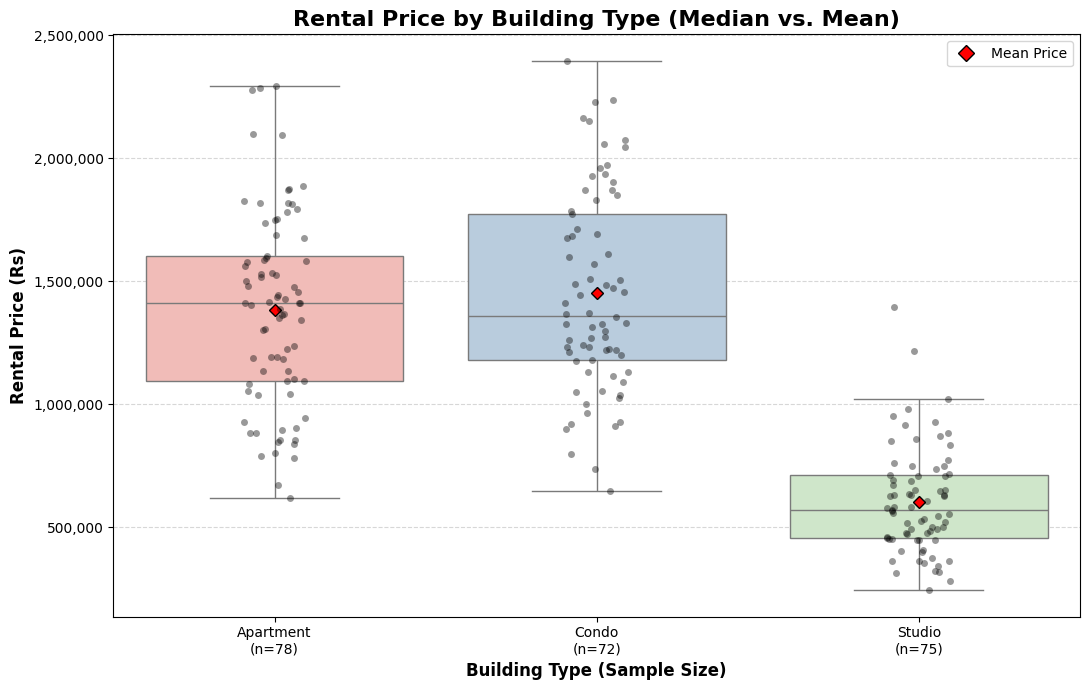

In [25]:
# 1. Prepare Data
# Sort by Median Price
median_order = df_clean.groupby('Building_Type')['Rental_Price_Rs'].median().sort_values(ascending=False).index

# Calculate Counts (N) for labels
counts = df_clean['Building_Type'].value_counts()
# Create new labels like "Condo\n(n=42)"
new_labels = [f"{etype.title()}\n(n={counts[etype]})" for etype in median_order]

plt.figure(figsize=(11, 7))

# LAYER 1: The Boxplot
sns.boxplot(
    data=df_clean,
    x='Building_Type',
    y='Rental_Price_Rs',
    order=median_order,
    palette='Pastel1',
    showfliers=False, 
    showmeans=True, # <--- NEW: Show the Mean
    meanprops={"marker":"D", "markerfacecolor":"red", "markeredgecolor":"black", "markersize":6} # Red Diamond = Mean
)

# LAYER 2: The Strip Plot
sns.stripplot(
    data=df_clean,
    x='Building_Type',
    y='Rental_Price_Rs',
    order=median_order,
    color='black',
    alpha=0.4,
    jitter=True
)

# 3. Formatting
ax = plt.gca()
ax.set_xticklabels(new_labels) # Set the new labels with (n=...)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.title('Rental Price by Building Type (Median vs. Mean)', fontsize=16, weight='bold')
plt.xlabel('Building Type (Sample Size)', fontsize=12, weight='bold')
plt.ylabel('Rental Price (Rs)', fontsize=12, weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add Legend for the Red Diamond
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='D', color='w', label='Mean Price',
                          markerfacecolor='red', markeredgecolor='black', markersize=8)]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

<h3 style='color:lightblue'>The Violin plot uses a mathematical formula (Kernel Density Estimation) to "smooth" the shape. It sees a point at 8K and a point at 12K and draws a curved line connecting them. It makes it look like data exists in the middle, even when it doesn't.</h3>

<h3>f.</h3>


### Calculation of Probability using Z-Score (Downtown < Rs 500k)

The problem requires finding the probability $P(X < \text{Rs } 500,000)$ assuming a normal distribution.

#### 1. Given Statistics
| Statistic | Symbol | Value (LKR) |
| :--- | :--- | :--- |
| Target Price | $X$ | 500,000.00 |
| Mean Price | $\mu$ | 1,528,837.46 |
| Std Deviation | $\sigma$ | 378,322.59 |

#### 2. Z-Score Calculation
The Z-score measures how many standard deviations the target value is from the mean.

$$ Z = \frac{X - \mu}{\sigma} = \frac{500,000 - 1,528,837}{378,323} $$

The calculated Z-score is:
$$ \mathbf{Z \approx -2.72} $$

#### 3. Probability Calculation
Using the Cumulative Distribution Function (CDF) for $Z = -2.72$:

$$ P(X < 500,000) = \Phi(-2.72) \approx \mathbf{0.0033} $$

#### 4. Conclusion
The probability of finding a Downtown apartment with a rental price below Rs 500,000 is **0.0033** (or **0.33%**).


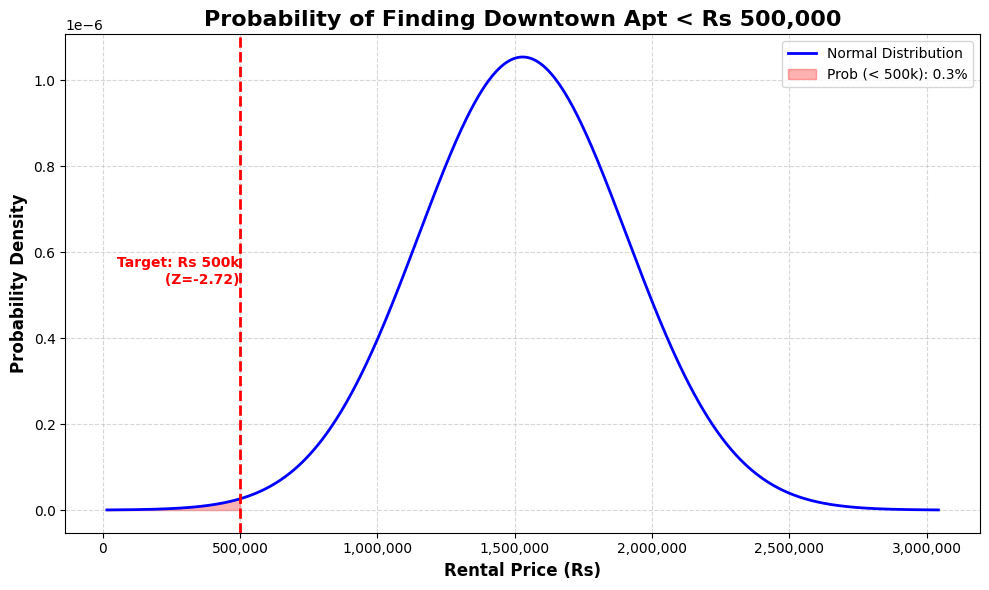

In [26]:
# 2. Filter for Downtown & Calculate Stats
downtown_data = df_apartment[df_apartment['Neighborhood'] == 'downtown']['Rental_Price_Rs']
mu = downtown_data.mean()
sigma = downtown_data.std()
target_price = 500000

# 3. Calculate Z-Score & Probability
z_score = (target_price - mu) / sigma
probability = stats.norm.cdf(z_score)

# --- PART A: Generate Markdown Report ---
output_text = f"""
### Calculation of Probability using Z-Score (Downtown < Rs 500k)

The problem requires finding the probability $P(X < \\text{{Rs }} 500,000)$ assuming a normal distribution.

#### 1. Given Statistics
| Statistic | Symbol | Value (LKR) |
| :--- | :--- | :--- |
| Target Price | $X$ | {target_price:,.2f} |
| Mean Price | $\\mu$ | {mu:,.2f} |
| Std Deviation | $\\sigma$ | {sigma:,.2f} |

#### 2. Z-Score Calculation
The Z-score measures how many standard deviations the target value is from the mean.

$$ Z = \\frac{{X - \\mu}}{{\\sigma}} = \\frac{{{target_price:,.0f} - {mu:,.0f}}}{{{sigma:,.0f}}} $$

The calculated Z-score is:
$$ \\mathbf{{Z \\approx {z_score:.2f}}} $$

#### 3. Probability Calculation
Using the Cumulative Distribution Function (CDF) for $Z = {z_score:.2f}$:

$$ P(X < 500,000) = \\Phi({z_score:.2f}) \\approx \\mathbf{{{probability:.4f}}} $$

#### 4. Conclusion
The probability of finding a Downtown apartment with a rental price below Rs 500,000 is **{probability:.4f}** (or **{probability*100:.2f}%**).
"""

# Display the formatted text
display(Markdown(output_text))

# --- PART B: Create the Visual Diagram ---
plt.figure(figsize=(10, 6))

# Generate the Bell Curve
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y = stats.norm.pdf(x, mu, sigma)
plt.plot(x, y, color='blue', linewidth=2, label='Normal Distribution')

# Shade the Area (Probability < 500k)
x_fill = np.linspace(mu - 4*sigma, target_price, 100)
y_fill = stats.norm.pdf(x_fill, mu, sigma)
plt.fill_between(x_fill, y_fill, color='red', alpha=0.3, label=f'Prob (< 500k): {probability:.1%}')

# Add the Target Line
plt.axvline(target_price, color='red', linestyle='--', linewidth=2)
plt.text(target_price, max(y)*0.5, f' Target: Rs 500k\n (Z={z_score:.2f})', 
         color='red', fontweight='bold', ha='right')

# Formatting
plt.title('Probability of Finding Downtown Apt < Rs 500,000', fontsize=16, weight='bold')
plt.xlabel('Rental Price (Rs)', fontsize=12, weight='bold')
plt.ylabel('Probability Density', fontsize=12, weight='bold')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

<h2>B Apartment Features & Their Influence</h2>
<h3>a.</h3>

C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\1253991917.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\1253991917.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


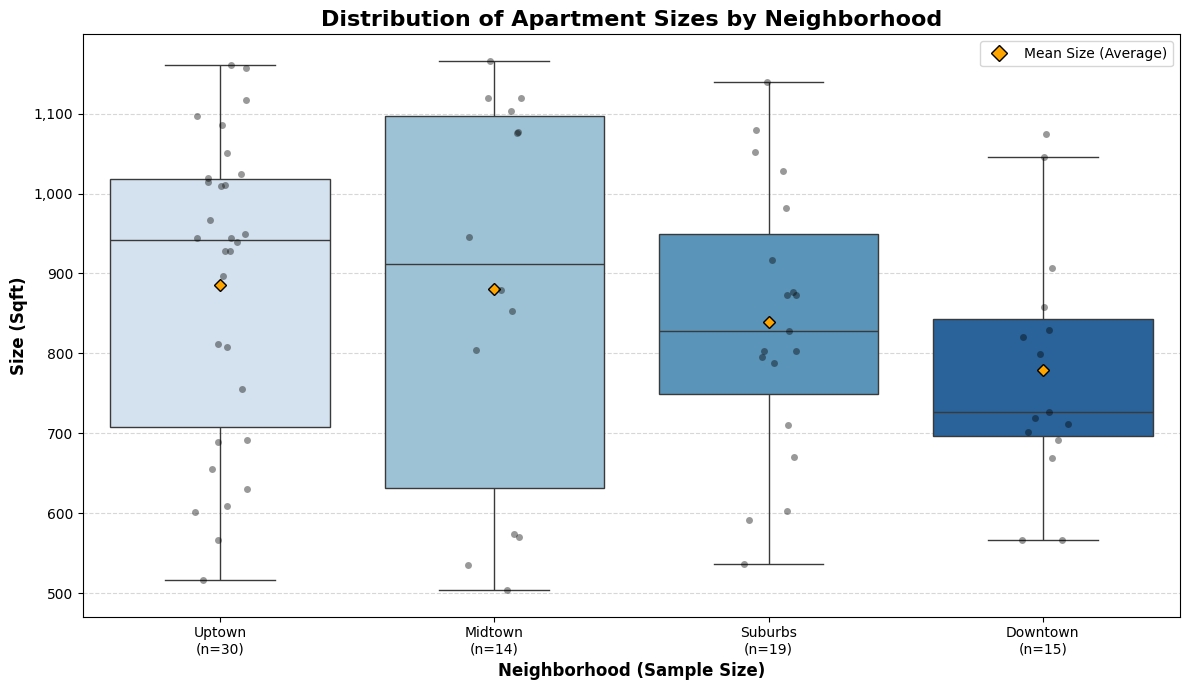

In [27]:
# 2. Prepare Data for Plotting
# Sort Neighborhoods by Median Size (Largest -> Smallest) to reveal the "Spatial Hierarchy"
median_order = df_apartment.groupby('Neighborhood')['Size_in_Sqft'].median().sort_values(ascending=False).index

# Calculate Counts (N) for labels
counts = df_apartment['Neighborhood'].value_counts()
new_labels = [f"{n.title()}\n(n={counts[n]})" for n in median_order]

# 3. Create the Visualization (Boxplot + Strip Plot)
plt.figure(figsize=(12, 7))

# LAYER 1: Boxplot (The Statistics)
sns.boxplot(
    data=df_apartment,
    x='Neighborhood',
    y='Size_in_Sqft',
    order=median_order,
    palette='Blues',  # Use Blue for size (psychologically neutral)
    showfliers=False, # Hide outliers here because we show them below
    showmeans=True,   # Show the Average
    meanprops={"marker":"D", "markerfacecolor":"orange", "markeredgecolor":"black", "markersize":6} # Orange Diamond = Mean
)

# LAYER 2: Strip Plot (The Raw Data)
sns.stripplot(
    data=df_apartment,
    x='Neighborhood',
    y='Size_in_Sqft',
    order=median_order,
    color='black',
    alpha=0.4,
    jitter=True # Spreads dots horizontally to show density
)

# 4. Formatting
ax = plt.gca()
ax.set_xticklabels(new_labels) 
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')) # Format 2,000

plt.title('Distribution of Apartment Sizes by Neighborhood', fontsize=16, weight='bold')
plt.xlabel('Neighborhood (Sample Size)', fontsize=12, weight='bold')
plt.ylabel('Size (Sqft)', fontsize=12, weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add Legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='D', color='w', label='Mean Size (Average)',
                          markerfacecolor='orange', markeredgecolor='black', markersize=8)]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

<h3>b.</h3>

C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\4021479167.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\4021479167.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


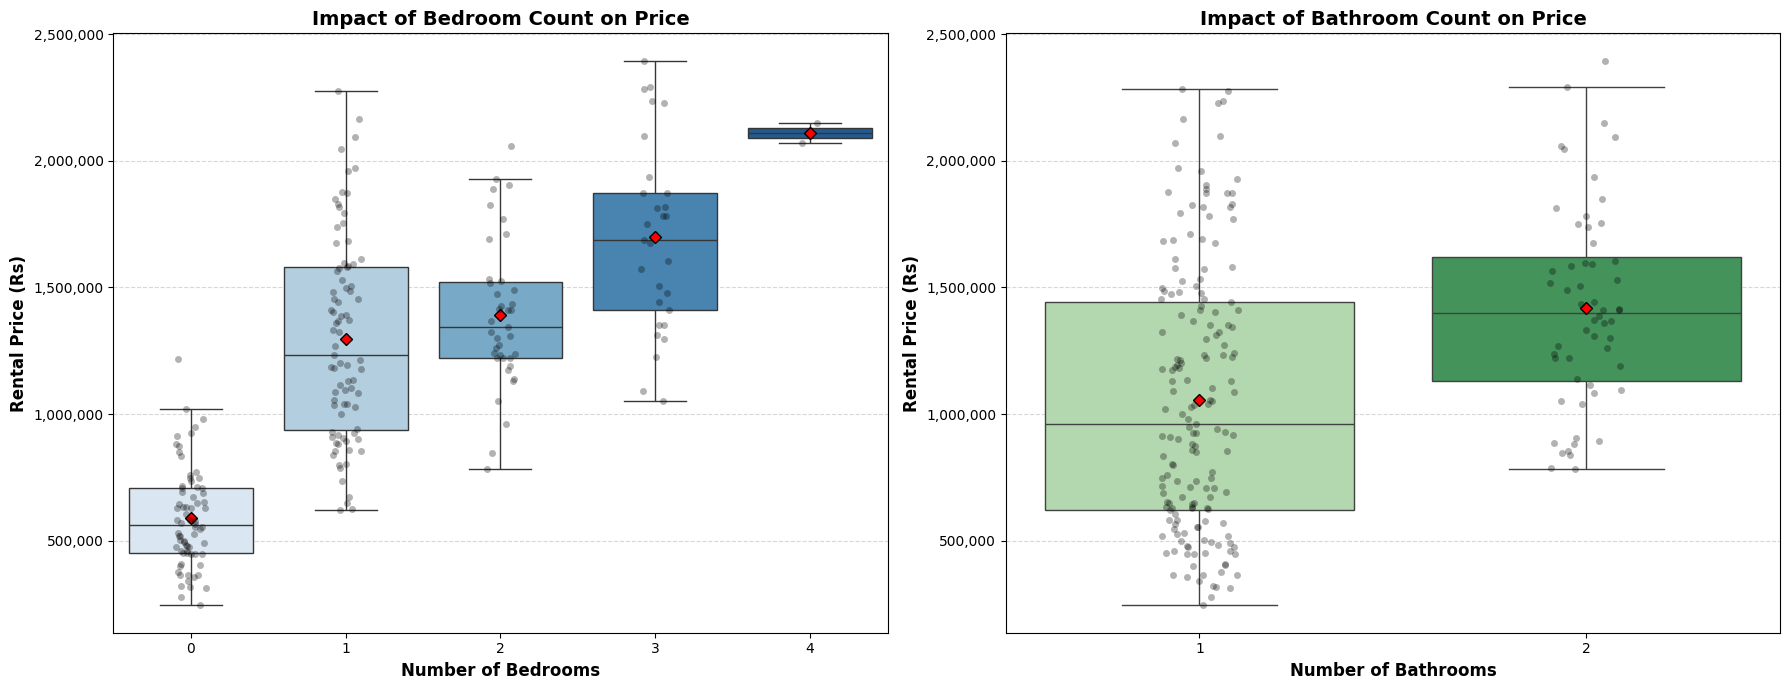

In [28]:
# 2. Create Side-by-Side Visuals
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Plot 1: Bedrooms vs. Price ---
sns.boxplot(
    data=df_clean,
    x='Bedrooms',
    y='Rental_Price_Rs',
    palette='Blues',
    showfliers=False, # Hide outliers to keep it clean
    showmeans=True,   # Show the Average (Red Diamond)
    meanprops={"marker":"D", "markerfacecolor":"red", "markeredgecolor":"black", "markersize":6},
    ax=axes[0]
)
# Add raw data points for transparency
sns.stripplot(data=df_clean, x='Bedrooms', y='Rental_Price_Rs', color='black', alpha=0.3, jitter=True, ax=axes[0])

axes[0].set_title('Impact of Bedroom Count on Price', fontsize=14, weight='bold')
axes[0].set_xlabel('Number of Bedrooms', fontsize=12, weight='bold')
axes[0].set_ylabel('Rental Price (Rs)', fontsize=12, weight='bold')
axes[0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# --- Plot 2: Bathrooms vs. Price ---
sns.boxplot(
    data=df_clean,
    x='Bathrooms',
    y='Rental_Price_Rs',
    palette='Greens',
    showfliers=False,
    showmeans=True,
    meanprops={"marker":"D", "markerfacecolor":"red", "markeredgecolor":"black", "markersize":6},
    ax=axes[1]
)
# Add raw data points
sns.stripplot(data=df_clean, x='Bathrooms', y='Rental_Price_Rs', color='black', alpha=0.3, jitter=True, ax=axes[1])

axes[1].set_title('Impact of Bathroom Count on Price', fontsize=14, weight='bold')
axes[1].set_xlabel('Number of Bathrooms', fontsize=12, weight='bold')
axes[1].set_ylabel('Rental Price (Rs)', fontsize=12, weight='bold')
axes[1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

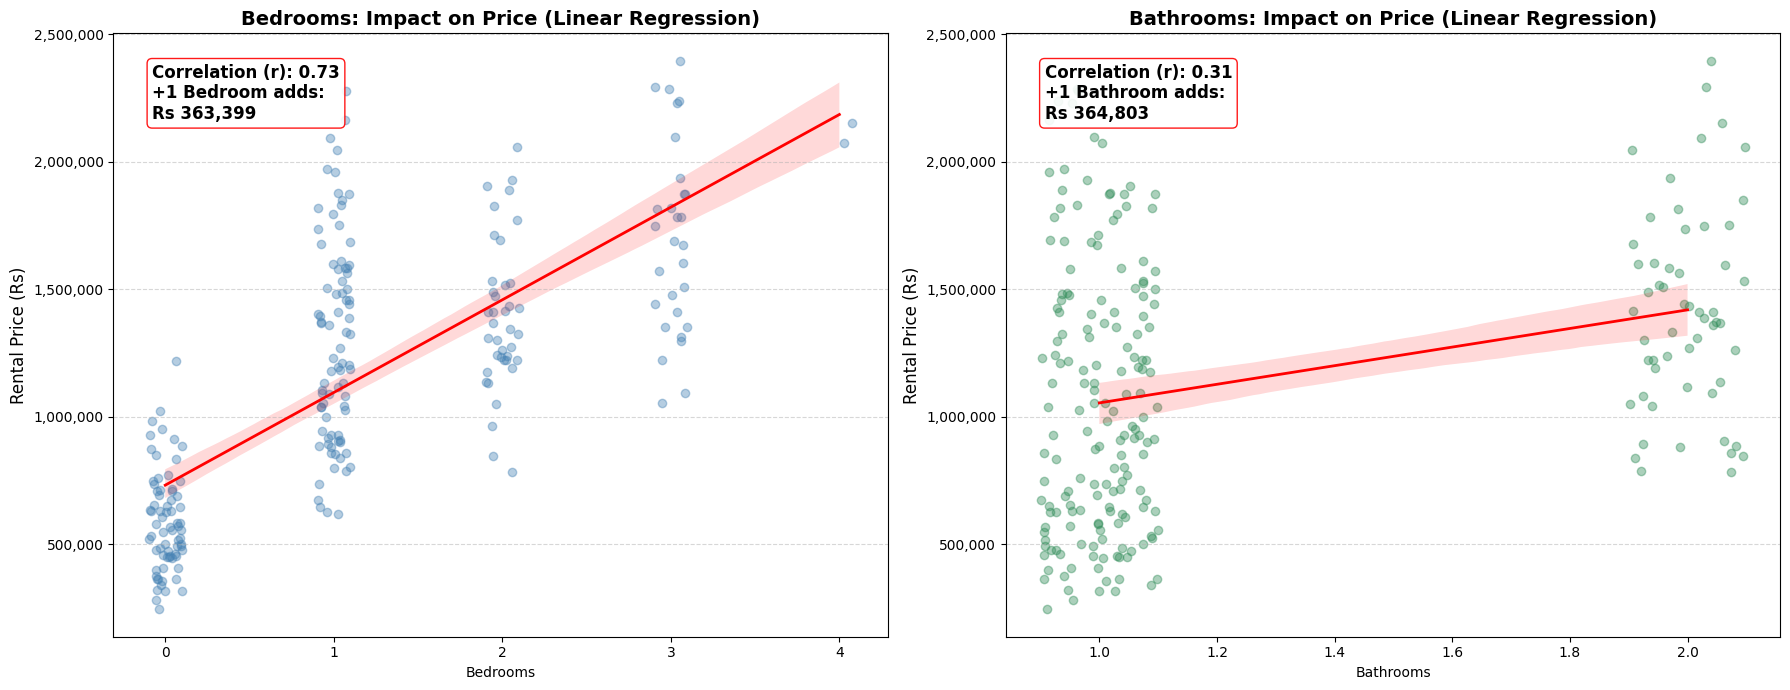

In [29]:
# 2. Calculate Regression Stats (The Math)
# This finds the "Slope" (Price increase per 1 unit)
slope_bed, intercept_bed, r_value_bed, p_value_bed, std_err_bed = stats.linregress(df_clean['Bedrooms'], df_clean['Rental_Price_Rs'])
slope_bath, intercept_bath, r_value_bath, p_value_bath, std_err_bath = stats.linregress(df_clean['Bathrooms'], df_clean['Rental_Price_Rs'])

# 3. Create Regression Plots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Plot 1: Bedrooms vs. Price (Regression) ---
sns.regplot(
    data=df_clean,
    x='Bedrooms',
    y='Rental_Price_Rs',
    x_jitter=0.1, # Add jitter so dots don't overlap perfectly
    scatter_kws={'alpha':0.4, 'color':'steelblue'},
    line_kws={'color':'red', 'linewidth':2},
    ax=axes[0]
)

# Add Stats Box
text_bed = f"Correlation (r): {r_value_bed:.2f}\n+1 Bedroom adds:\nRs {slope_bed:,.0f}"
axes[0].text(
    0.05, 0.95, text_bed, transform=axes[0].transAxes,
    fontsize=12, verticalalignment='top', weight='bold',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='red')
)

axes[0].set_title('Bedrooms: Impact on Price (Linear Regression)', fontsize=14, weight='bold')
axes[0].set_ylabel('Rental Price (Rs)', fontsize=12)
axes[0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# --- Plot 2: Bathrooms vs. Price (Regression) ---
sns.regplot(
    data=df_clean,
    x='Bathrooms',
    y='Rental_Price_Rs',
    x_jitter=0.1,
    scatter_kws={'alpha':0.4, 'color':'seagreen'},
    line_kws={'color':'red', 'linewidth':2},
    ax=axes[1]
)

# Add Stats Box
text_bath = f"Correlation (r): {r_value_bath:.2f}\n+1 Bathroom adds:\nRs {slope_bath:,.0f}"
axes[1].text(
    0.05, 0.95, text_bath, transform=axes[1].transAxes,
    fontsize=12, verticalalignment='top', weight='bold',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='red')
)

axes[1].set_title('Bathrooms: Impact on Price (Linear Regression)', fontsize=14, weight='bold')
axes[1].set_ylabel('Rental Price (Rs)', fontsize=12)
axes[1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

<h3>c.</h3>

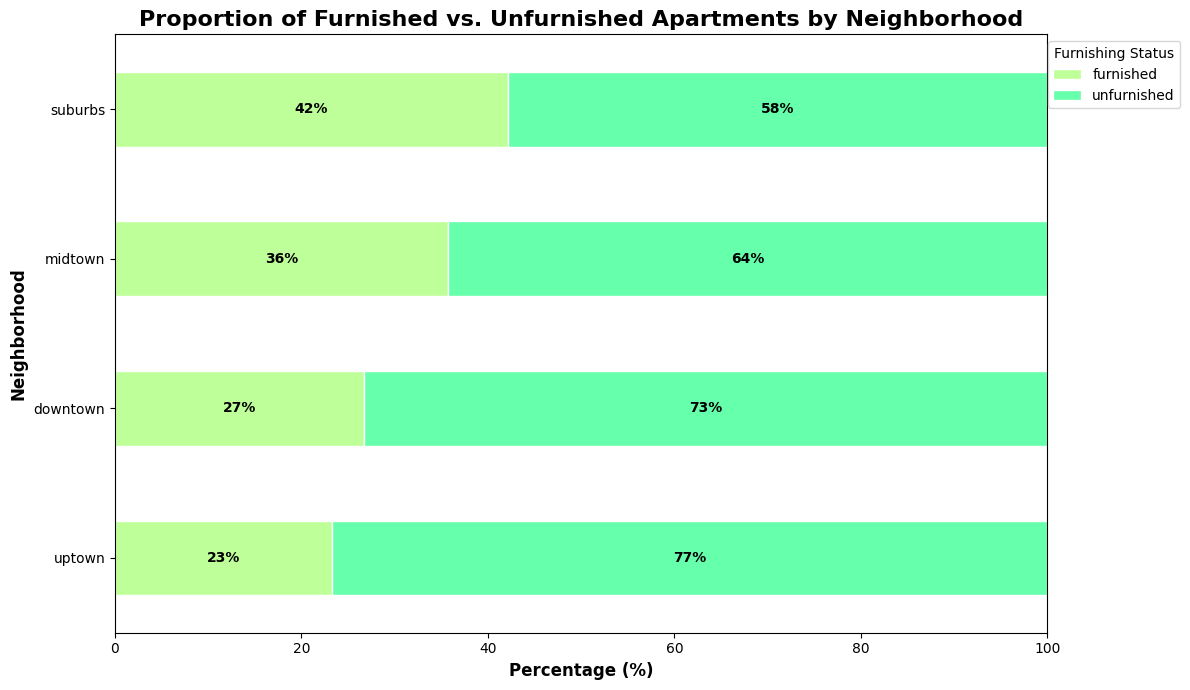

In [30]:
# 2. Prepare Data: Cross-tabulation (Proportions)
# normalize='index' calculates the percentage for each row (Neighborhood)
neighborhood_furnishing = pd.crosstab(
    df_apartment['Neighborhood'], 
    df_apartment['Furnished'], 
    normalize='index'
) * 100

# Sort by 'furnished' percentage to make the chart organized (Highest Furnished -> Lowest)
# This makes it easier to read ("Who has the most furnished units?")
if 'furnished' in neighborhood_furnishing.columns:
    neighborhood_furnishing = neighborhood_furnishing.sort_values(by='furnished', ascending=True)

# 3. Create the 100% Stacked Bar Chart
ax = neighborhood_furnishing.plot(
    kind='barh', 
    stacked=True, 
    figsize=(12, 7), 
    color=["#beff99", "#66ffab"], # Custom colors (Reddish for Furnished, Blueish for Unfurnished)
    edgecolor='white'
)

# 4. Formatting
plt.title('Proportion of Furnished vs. Unfurnished Apartments by Neighborhood', fontsize=16, weight='bold')
plt.xlabel('Percentage (%)', fontsize=12, weight='bold')
plt.ylabel('Neighborhood', fontsize=12, weight='bold')
plt.legend(title='Furnishing Status', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.xlim(0, 100) # Ensure axis goes from 0 to 100%

# Add Percentage Labels inside the bars
for c in ax.containers:
    # customize the label format to be integer% (e.g., 45%)
    # label_type='center' puts the text in the middle of the bar segment
    ax.bar_label(c, fmt='%.0f%%', label_type='center', color='black', weight='bold', fontsize=10)

plt.tight_layout()
plt.show()

In [65]:
df_clean.to_csv('df_cleaned.csv')

<h3>d.</h3>

C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\2791029119.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\2791029119.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


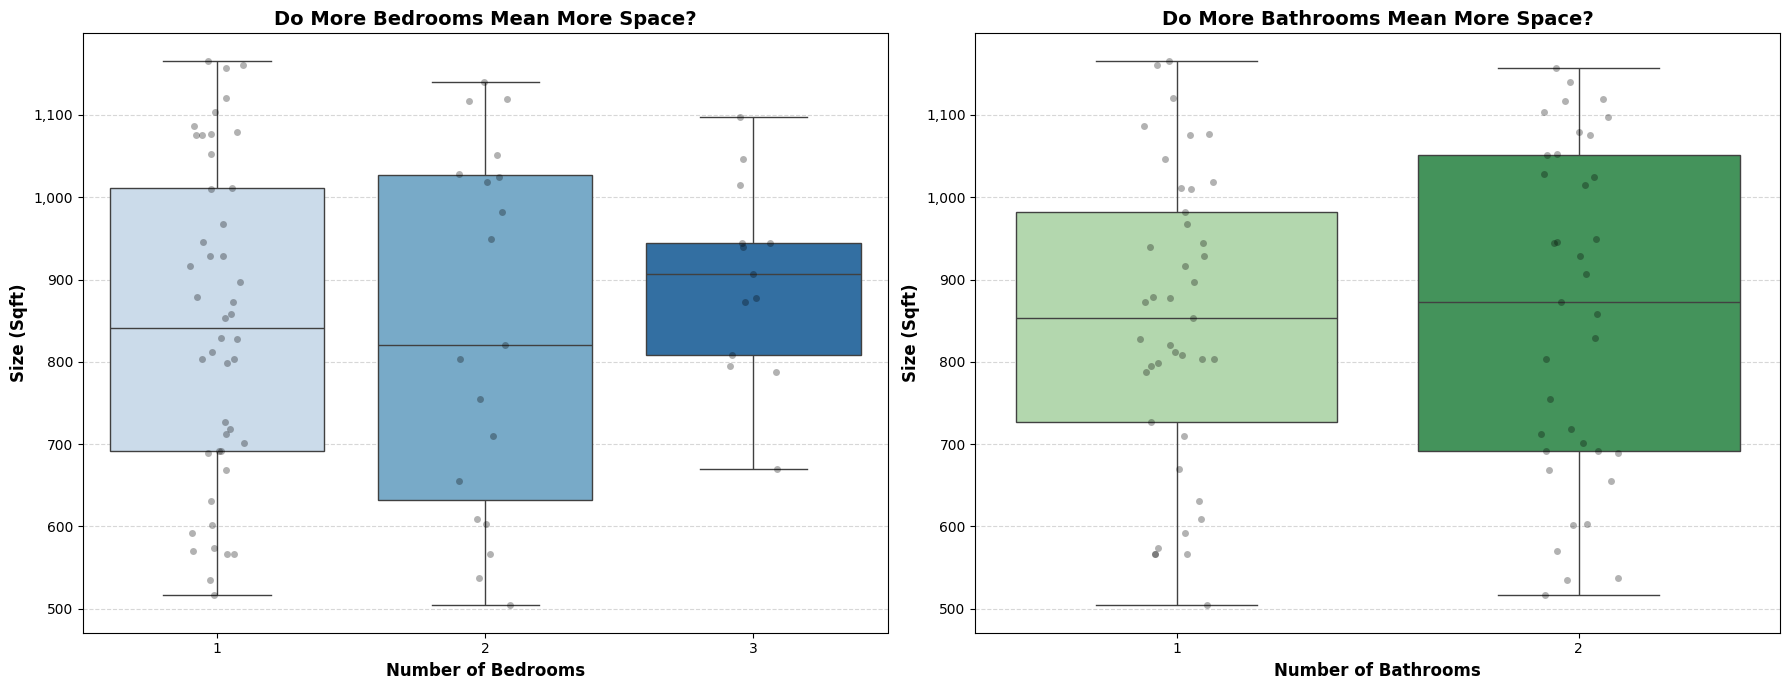

In [31]:
# 3. Create the Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Plot 1: Bedrooms vs. Size ---
sns.boxplot(
    data=df_apartment,
    x='Bedrooms',
    y='Size_in_Sqft',
    palette='Blues',
    showfliers=False, # Hide outliers here (we show them with dots)
    ax=axes[0]
)
# Overlay raw data points (Jitter)
sns.stripplot(
    data=df_apartment,
    x='Bedrooms',
    y='Size_in_Sqft',
    color='black',
    alpha=0.3,
    jitter=True,
    ax=axes[0]
)

axes[0].set_title('Do More Bedrooms Mean More Space?', fontsize=14, weight='bold')
axes[0].set_xlabel('Number of Bedrooms', fontsize=12, weight='bold')
axes[0].set_ylabel('Size (Sqft)', fontsize=12, weight='bold')
axes[0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# --- Plot 2: Bathrooms vs. Size ---
sns.boxplot(
    data=df_apartment,
    x='Bathrooms',
    y='Size_in_Sqft',
    palette='Greens',
    showfliers=False,
    ax=axes[1]
)
sns.stripplot(
    data=df_apartment,
    x='Bathrooms',
    y='Size_in_Sqft',
    color='black',
    alpha=0.3,
    jitter=True,
    ax=axes[1]
)

axes[1].set_title('Do More Bathrooms Mean More Space?', fontsize=14, weight='bold')
axes[1].set_xlabel('Number of Bathrooms', fontsize=12, weight='bold')
axes[1].set_ylabel('Size (Sqft)', fontsize=12, weight='bold')
axes[1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

<h2>C Neighborhood Comparisons</h2>
<h3>a.</h3>

C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\2172934643.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\2172934643.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


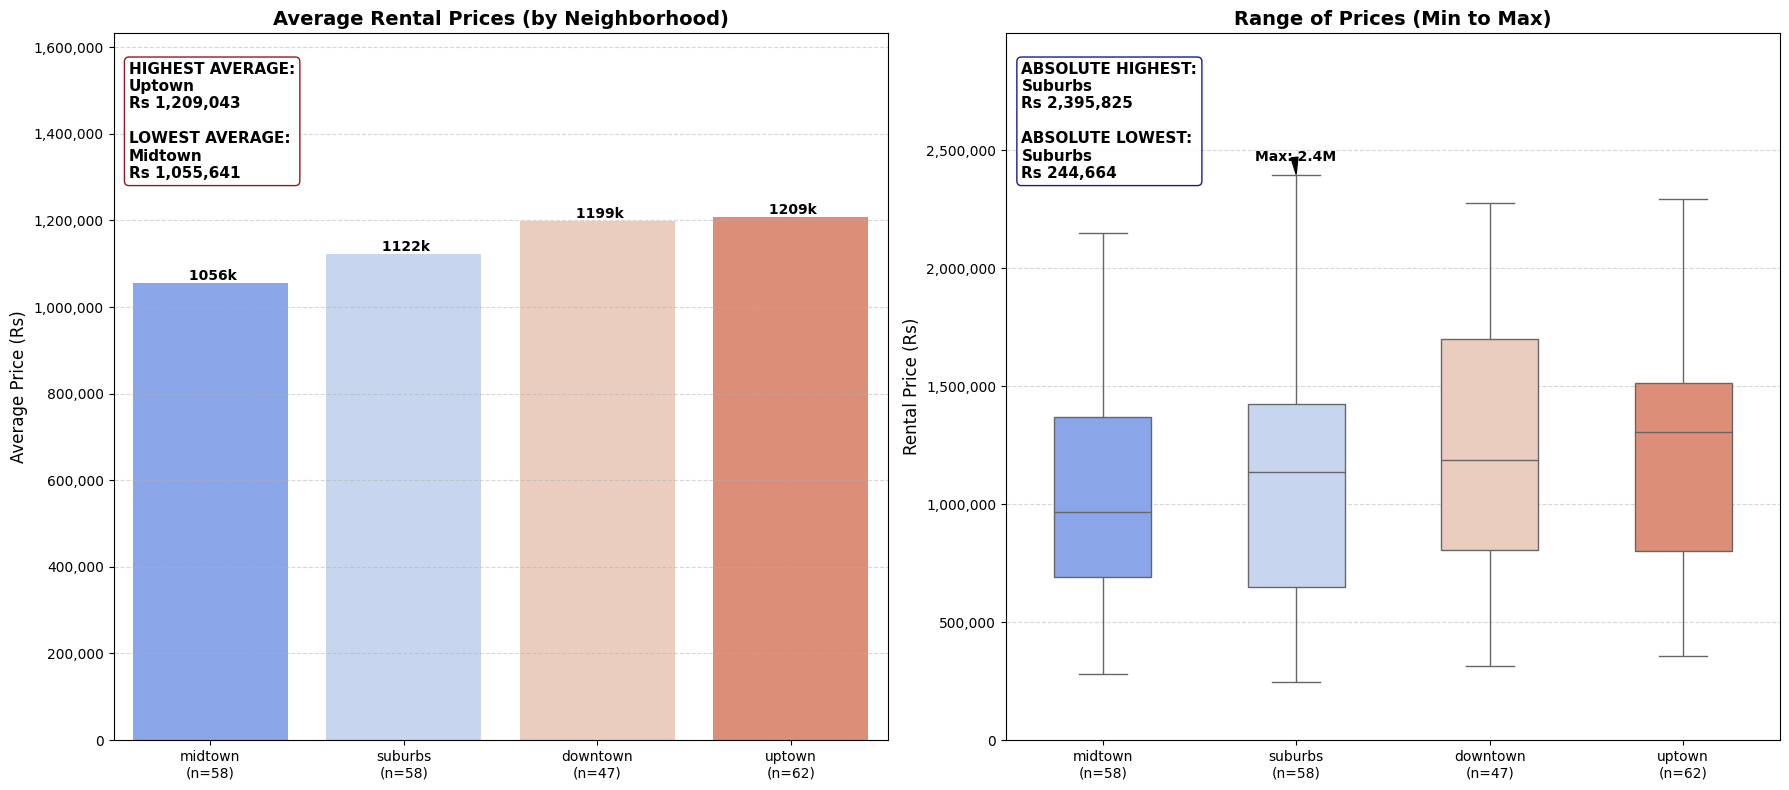

In [32]:
# 2. Prepare Stats for Labels and Sorting
stats = df_clean.groupby('Neighborhood')['Rental_Price_Rs'].agg(['mean', 'min', 'max', 'count']).sort_values('mean')

# Create labels with 'n' counts
# e.g., "Downtown\n(n=45)"
stats['label'] = stats.index + '\n(n=' + stats['count'].astype(str) + ')'
df_clean['label'] = df_clean['Neighborhood'].map(dict(zip(stats.index, stats['label'])))
order = stats['label'].tolist()

# 3. Create Subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# --- PLOT 1: AVERAGE Prices (Bar Chart) ---
sns.barplot(
    x=stats['label'],
    y=stats['mean'],
    palette='coolwarm',
    ax=axes[0]
)

# Adjust Y-Limit to make space for the box at the top
max_mean = stats['mean'].max()
axes[0].set_ylim(0, max_mean * 1.35)  # Add 35% headroom

# Stats Box (Average)
highest_avg = stats.iloc[-1]
lowest_avg = stats.iloc[0]
text_avg = (
    f"HIGHEST AVERAGE:\n{highest_avg.name.title()}\nRs {highest_avg['mean']:,.0f}\n\n"
    f"LOWEST AVERAGE:\n{lowest_avg.name.title()}\nRs {lowest_avg['mean']:,.0f}"
)

# Place box in the top-left corner (now empty due to ylim)
axes[0].text(
    0.02, 0.96, text_avg, transform=axes[0].transAxes,
    fontsize=11, verticalalignment='top', weight='bold',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='darkred')
)

# Formatting Plot 1
axes[0].set_title('Average Rental Prices (by Neighborhood)', fontsize=14, weight='bold')
axes[0].set_ylabel('Average Price (Rs)', fontsize=12)
axes[0].set_xlabel('')
axes[0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels on bars
for i, v in enumerate(stats['mean']):
    axes[0].text(i, v, f" {v/1000:.0f}k", ha='center', va='bottom', fontweight='bold')


# --- PLOT 2: ABSOLUTE Prices (Box Plot) ---
sns.boxplot(
    data=df_clean,
    x='label',
    y='Rental_Price_Rs',
    order=order,
    palette='coolwarm',
    width=0.5,
    ax=axes[1]
)

# Adjust Y-Limit for Box Plot
max_price = df_clean['Rental_Price_Rs'].max()
axes[1].set_ylim(0, max_price * 1.25) # Add 25% headroom

# Stats Box (Absolute)
abs_max_row = df_clean.loc[df_clean['Rental_Price_Rs'].idxmax()]
abs_min_row = df_clean.loc[df_clean['Rental_Price_Rs'].idxmin()]

text_abs = (
    f"ABSOLUTE HIGHEST:\n{abs_max_row['Neighborhood'].title()}\nRs {abs_max_row['Rental_Price_Rs']:,.0f}\n\n"
    f"ABSOLUTE LOWEST:\n{abs_min_row['Neighborhood'].title()}\nRs {abs_min_row['Rental_Price_Rs']:,.0f}"
)

axes[1].text(
    0.02, 0.96, text_abs, transform=axes[1].transAxes,
    fontsize=11, verticalalignment='top', weight='bold',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='darkblue')
)

# Annotate Max Price Point
axes[1].annotate(
    f"Max: {abs_max_row['Rental_Price_Rs']/1000000:.1f}M",
    xy=(order.index(df_clean.loc[df_clean['Rental_Price_Rs'].idxmax(), 'label']), abs_max_row['Rental_Price_Rs']),
    xytext=(-30, 10), textcoords='offset points',
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
    fontweight='bold'
)

# Formatting Plot 2
axes[1].set_title('Range of Prices (Min to Max)', fontsize=14, weight='bold')
axes[1].set_ylabel('Rental Price (Rs)', fontsize=12)
axes[1].set_xlabel('')
axes[1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

<h3>b.</h3>

C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\3558529217.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apartment['label'] = df_apartment['Neighborhood'].map(dict(zip(stats.index, stats['label'])))
C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\3558529217.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\3558529217.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


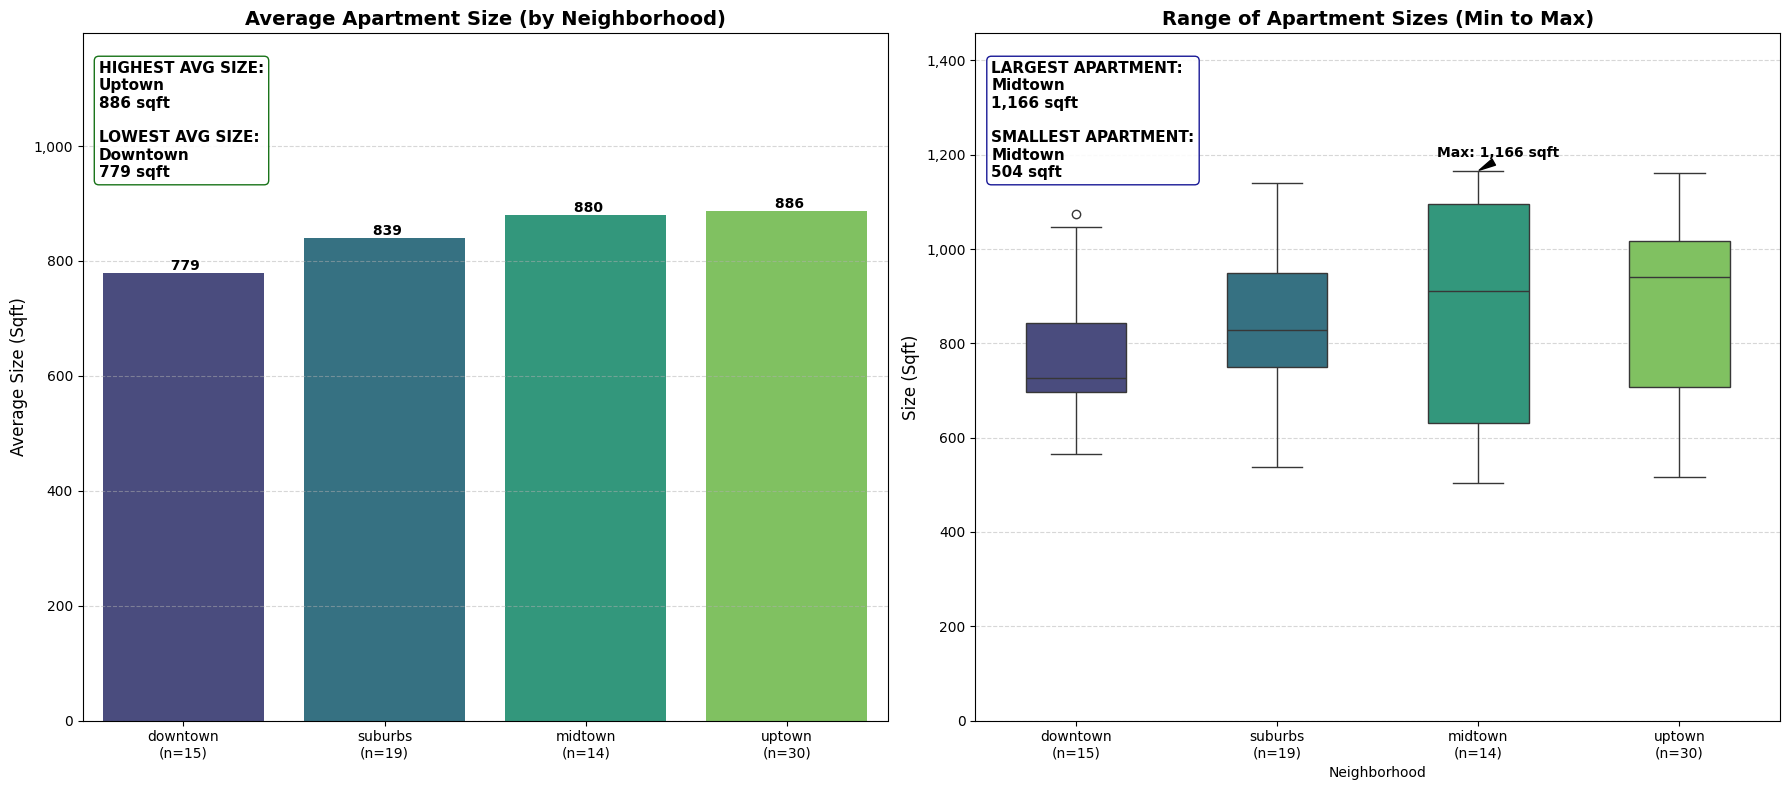

In [33]:
# 2. Prepare Stats for Labels and Sorting
# Grouping by Neighborhood to get stats for Size_in_Sqft
stats = df_apartment.groupby('Neighborhood')['Size_in_Sqft'].agg(['mean', 'min', 'max', 'count']).sort_values('mean')

# Create labels with 'n' counts
stats['label'] = stats.index + '\n(n=' + stats['count'].astype(str) + ')'
df_apartment['label'] = df_apartment['Neighborhood'].map(dict(zip(stats.index, stats['label'])))
order = stats['label'].tolist()

# 3. Create Subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# --- PLOT 1: AVERAGE Size (Bar Chart) ---
sns.barplot(
    x=stats['label'],
    y=stats['mean'],
    palette='viridis',
    ax=axes[0]
)

# Adjust Y-Limit to make space for the box at the top
max_mean = stats['mean'].max()
axes[0].set_ylim(0, max_mean * 1.35)

# Stats Box (Average)
highest_avg = stats.iloc[-1]
lowest_avg = stats.iloc[0]
text_avg = (
    f"HIGHEST AVG SIZE:\n{highest_avg.name.title()}\n{highest_avg['mean']:,.0f} sqft\n\n"
    f"LOWEST AVG SIZE:\n{lowest_avg.name.title()}\n{lowest_avg['mean']:,.0f} sqft"
)

# Place box in the top-left corner
axes[0].text(
    0.02, 0.96, text_avg, transform=axes[0].transAxes,
    fontsize=11, verticalalignment='top', weight='bold',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='darkgreen')
)

# Formatting Plot 1
axes[0].set_title('Average Apartment Size (by Neighborhood)', fontsize=14, weight='bold')
axes[0].set_ylabel('Average Size (Sqft)', fontsize=12)
axes[0].set_xlabel('')
axes[0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels on bars
for i, v in enumerate(stats['mean']):
    axes[0].text(i, v, f" {v:,.0f}", ha='center', va='bottom', fontweight='bold')


# --- PLOT 2: ABSOLUTE Size Ranges (Box Plot) ---
sns.boxplot(
    data=df_apartment,
    x='label',
    y='Size_in_Sqft',
    order=order,
    palette='viridis',
    width=0.5,
    ax=axes[1]
)

# Adjust Y-Limit for Box Plot
max_size = df_apartment['Size_in_Sqft'].max()
axes[1].set_ylim(0, max_size * 1.25)

# Stats Box (Absolute)
abs_max_row = df_apartment.loc[df_apartment['Size_in_Sqft'].idxmax()]
abs_min_row = df_apartment.loc[df_apartment['Size_in_Sqft'].idxmin()]

text_abs = (
    f"LARGEST APARTMENT:\n{abs_max_row['Neighborhood'].title()}\n{abs_max_row['Size_in_Sqft']:,.0f} sqft\n\n"
    f"SMALLEST APARTMENT:\n{abs_min_row['Neighborhood'].title()}\n{abs_min_row['Size_in_Sqft']:,.0f} sqft"
)

axes[1].text(
    0.02, 0.96, text_abs, transform=axes[1].transAxes,
    fontsize=11, verticalalignment='top', weight='bold',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='darkblue')
)

# Annotate Max Size Point
axes[1].annotate(
    f"Max: {abs_max_row['Size_in_Sqft']:,.0f} sqft",
    xy=(order.index(df_apartment.loc[df_apartment['Size_in_Sqft'].idxmax(), 'label']), abs_max_row['Size_in_Sqft']),
    xytext=(-30, 10), textcoords='offset points',
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
    fontweight='bold'
)

# Formatting Plot 2
axes[1].set_title('Range of Apartment Sizes (Min to Max)', fontsize=14, weight='bold')
axes[1].set_ylabel('Size (Sqft)', fontsize=12)
axes[1].set_xlabel('Neighborhood')
axes[1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

<h3>c.</h3>

C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\975325457.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


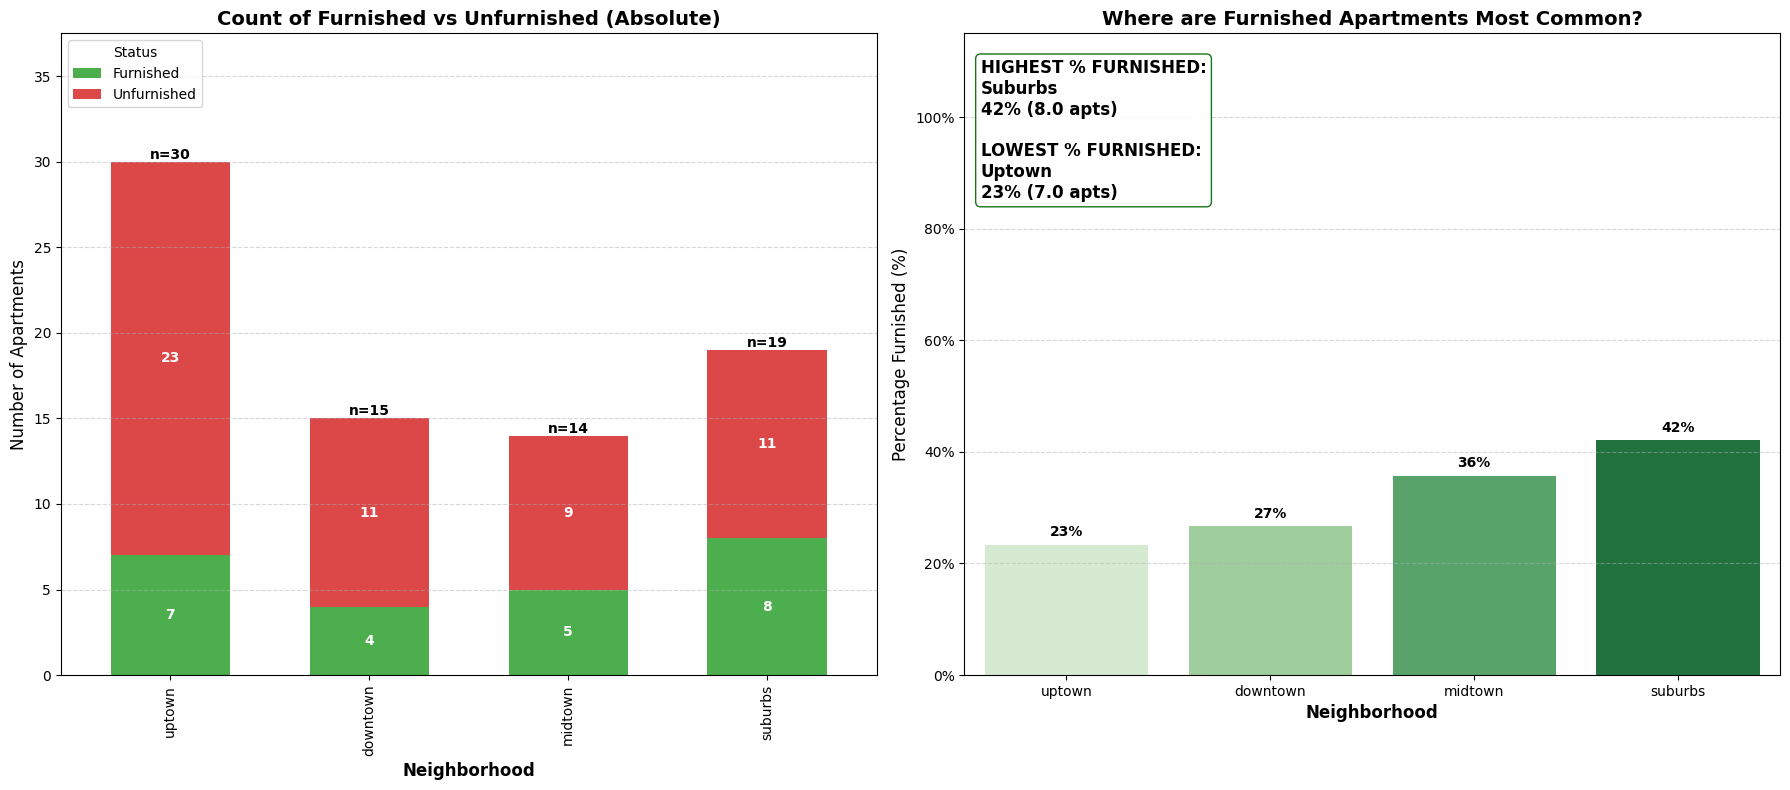

In [34]:
# 2. Prepare Data
# Count furnished vs unfurnished per neighborhood
furnished_counts = df_apartment.groupby(['Neighborhood', 'Furnished']).size().unstack(fill_value=0)

# Calculate Total and Percentage
furnished_counts['Total'] = furnished_counts.sum(axis=1)
furnished_counts['Furnished_Pct'] = (furnished_counts['furnished'] / furnished_counts['Total']) * 100

# Sort by Percentage for consistent plotting
furnished_counts_sorted = furnished_counts.sort_values('Furnished_Pct', ascending=True)

# 3. Create Subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# --- PLOT 1: Absolute Counts (Stacked Bar) ---
# We use the sorted index so both charts match order
plot_data = furnished_counts_sorted[['furnished', 'unfurnished']]

# Plotting
plot_data.plot(kind='bar', stacked=True, ax=axes[0], color=['#2ca02c', '#d62728'], alpha=0.85, width=0.6)
# #2ca02c is Green (Furnished), #d62728 is Red (Unfurnished)

# Formatting Plot 1
axes[0].set_title('Count of Furnished vs Unfurnished (Absolute)', fontsize=14, weight='bold')
axes[0].set_ylabel('Number of Apartments', fontsize=12)
axes[0].set_xlabel('Neighborhood', fontsize=12, weight='bold')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
axes[0].legend(title='Status', labels=['Furnished', 'Unfurnished'], loc='upper left')

# Add number labels inside the bars
for c in axes[0].containers:
    axes[0].bar_label(c, label_type='center', fontweight='bold', color='white', fontsize=10)

# Add "n=" at the top of each bar
for i, total in enumerate(furnished_counts_sorted['Total']):
    axes[0].text(i, total, f"\nn={total}", ha='center', va='bottom', fontweight='bold', color='black')

# Add headroom
axes[0].set_ylim(0, furnished_counts_sorted['Total'].max() * 1.25)


# --- PLOT 2: Percentage Furnished (Bar Chart) ---
sns.barplot(
    x=furnished_counts_sorted.index,
    y=furnished_counts_sorted['Furnished_Pct'],
    palette='Greens',
    ax=axes[1]
)

# Stats Box
highest_row = furnished_counts_sorted.iloc[-1]
lowest_row = furnished_counts_sorted.iloc[0]

text_stats = (
    f"HIGHEST % FURNISHED:\n{highest_row.name.title()}\n{highest_row['Furnished_Pct']:.0f}% ({highest_row['furnished']} apts)\n\n"
    f"LOWEST % FURNISHED:\n{lowest_row.name.title()}\n{lowest_row['Furnished_Pct']:.0f}% ({lowest_row['furnished']} apts)"
)

# Place box in top-left
axes[1].text(
    0.02, 0.96, text_stats, transform=axes[1].transAxes,
    fontsize=12, verticalalignment='top', weight='bold',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='darkgreen')
)

# Formatting Plot 2
axes[1].set_title('Where are Furnished Apartments Most Common?', fontsize=14, weight='bold')
axes[1].set_ylabel('Percentage Furnished (%)', fontsize=12)
axes[1].set_xlabel('Neighborhood', fontsize=12, weight='bold')
axes[1].set_ylim(0, 115) # Scale to 100%
axes[1].yaxis.set_major_formatter(ticker.PercentFormatter())
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# Add % labels on top of bars
for i, v in enumerate(furnished_counts_sorted['Furnished_Pct']):
    axes[1].text(i, v + 1, f"{v:.0f}%", ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

<h2>D Market Dynamics & Outliers</h2>
<h3>a.</h3>

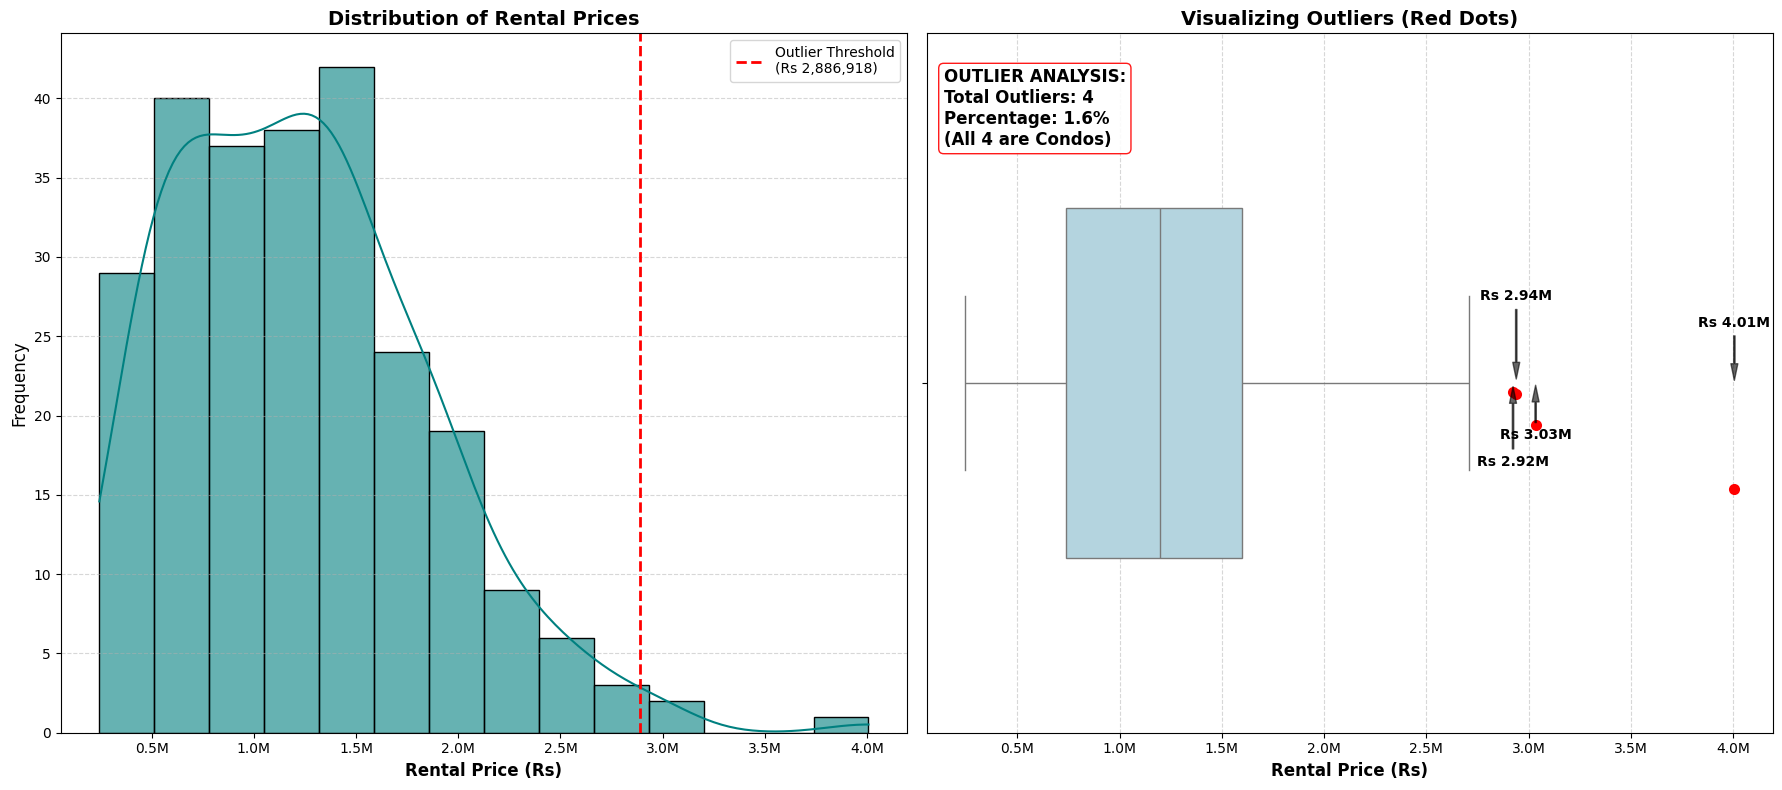

In [35]:
# 2. Identify Outliers (IQR Method)
Q1 = df['Rental_Price_Rs'].quantile(0.25)
Q3 = df['Rental_Price_Rs'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter for outliers
outliers = df[(df['Rental_Price_Rs'] < lower_bound) | (df['Rental_Price_Rs'] > upper_bound)]

# 3. Create Subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# --- PLOT 1: Distribution (Histogram) ---
sns.histplot(
    data=df,
    x='Rental_Price_Rs',
    kde=True,
    color='teal',
    edgecolor='black',
    alpha=0.6,
    ax=axes[0]
)

# Mark the Upper Limit
axes[0].axvline(upper_bound, color='red', linestyle='--', linewidth=2, label=f'Outlier Threshold\n(Rs {upper_bound:,.0f})')
axes[0].legend(loc='upper right')

# Formatting Plot 1
axes[0].set_title('Distribution of Rental Prices', fontsize=14, weight='bold')
axes[0].set_xlabel('Rental Price (Rs)', fontsize=12, weight='bold')
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000000:.1f}M'))
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# --- PLOT 2: Outliers (Box Plot) ---
# Hide default fliers (outliers) in boxplot to avoid duplicates
sns.boxplot(
    x=df['Rental_Price_Rs'],
    color='lightblue',
    width=0.5,
    flierprops={"marker": "None"}, 
    ax=axes[1]
)

# Overlay points with jitter using stripplot
# We plot only the outliers in red to highlight them
sns.stripplot(
    x=outliers['Rental_Price_Rs'],
    color='red',
    size=8,
    jitter=0.2, # Adds vertical jitter
    ax=axes[1]
)

# Stats Box
num_outliers = len(outliers)
outlier_percentage = (num_outliers / len(df)) * 100

text_stats = (
    f"OUTLIER ANALYSIS:\n"
    f"Total Outliers: {num_outliers}\n"
    f"Percentage: {outlier_percentage:.1f}%\n"
    f"(All {num_outliers} are Condos)"
)

# Place box in top-left
axes[1].text(
    0.02, 0.95, text_stats, transform=axes[1].transAxes,
    fontsize=12, verticalalignment='top', weight='bold',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='red')
)

# Annotate specific outlier points with staggered labels to avoid overlap
if num_outliers > 0:
    top_outliers = outliers.sort_values('Rental_Price_Rs', ascending=False)
    
    # Define offsets to cycle through: (x_offset, y_offset)
    # This pushes labels Up, Down, Higher Up, Lower Down...
    offsets = [(0, 40), (0, -40), (0, 60), (0, -60)] 
    
    for i, (idx, row) in enumerate(top_outliers.iterrows()):
        offset_x, offset_y = offsets[i % len(offsets)]
        
        axes[1].annotate(
            f"Rs {row['Rental_Price_Rs']/1000000:.2f}M",
            xy=(row['Rental_Price_Rs'], 0), # Points cluster around y=0 in boxplot
            xytext=(offset_x, offset_y), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5, alpha=0.6),
            fontweight='bold', ha='center'
        )

# Formatting Plot 2
axes[1].set_title('Visualizing Outliers (Red Dots)', fontsize=14, weight='bold')
axes[1].set_xlabel('Rental Price (Rs)', fontsize=12, weight='bold')
axes[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000000:.1f}M'))
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

<h3>b.</h3>

C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\2464556300.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = df_apartment.groupby('Neighborhood').apply(lambda x: x['Size_in_Sqft'].corr(x['Rental_Price_Rs'])).sort_values(ascending=False)


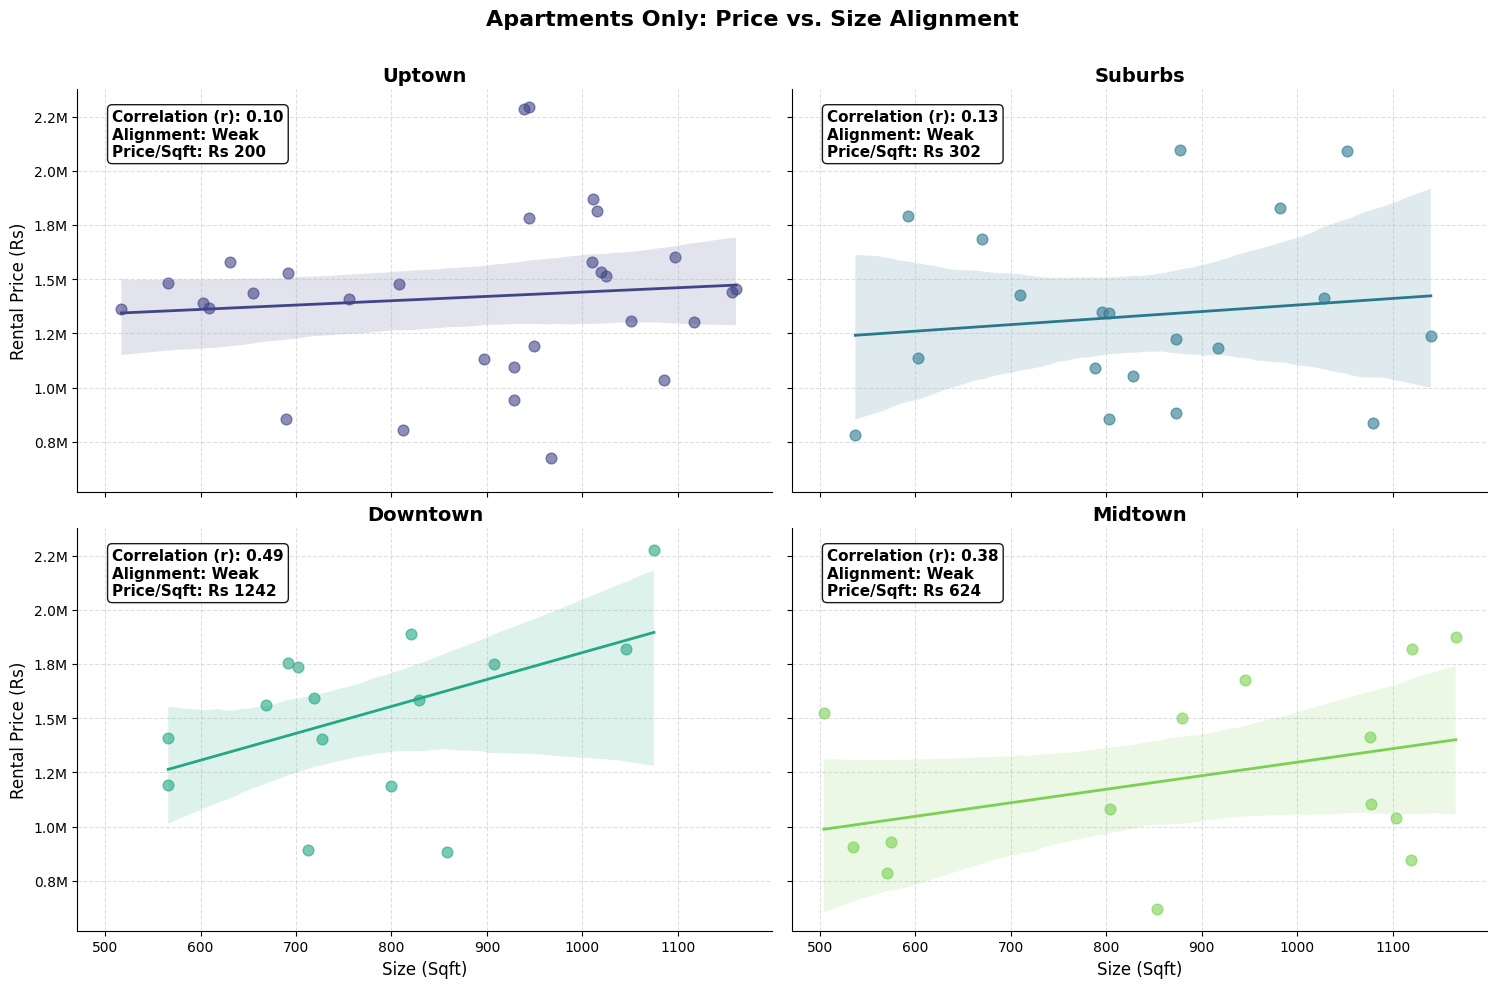

Apartment Correlations:
 Neighborhood
downtown    0.490980
midtown     0.378042
suburbs     0.126511
uptown      0.101615
dtype: float64


In [38]:
# 3. Calculate Correlations for Apartments
correlations = df_apartment.groupby('Neighborhood').apply(lambda x: x['Size_in_Sqft'].corr(x['Rental_Price_Rs'])).sort_values(ascending=False)

# 4. Create Plot
g = sns.lmplot(
    data=df_apartment,
    x='Size_in_Sqft',
    y='Rental_Price_Rs',
    col='Neighborhood',
    col_wrap=2,
    hue='Neighborhood',
    palette='viridis',
    height=5,
    aspect=1.5,
    scatter_kws={'alpha': 0.6, 's': 60},
    line_kws={'linewidth': 2}
)

# 5. Add Stats to each subplot
axes = g.axes.flatten()
for i, ax in enumerate(axes):
    neighborhood_name = ax.get_title().split('=')[-1].strip()
    
    subset = df_apartment[df_apartment['Neighborhood'] == neighborhood_name]
    
    # Check if we have enough data points for regression
    if len(subset) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(subset['Size_in_Sqft'], subset['Rental_Price_Rs'])
        
        stats_text = (
            f"Correlation (r): {r_value:.2f}\n"
            f"Alignment: {'Strong' if r_value > 0.8 else 'Moderate' if r_value > 0.5 else 'Weak'}\n"
            f"Price/Sqft: Rs {slope:.0f}"
        )
    else:
        stats_text = "Not enough data"
        r_value = 0 # Default for sorting/display logic if needed

    ax.text(
        0.05, 0.95, stats_text, transform=ax.transAxes,
        fontsize=11, verticalalignment='top', weight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black')
    )
    
    ax.set_title(neighborhood_name.title(), fontsize=14, weight='bold')
    # Only label y-axis for the left column (indices 0 and 2)
    if i % 2 == 0:
        ax.set_ylabel('Rental Price (Rs)', fontsize=12)
    else:
        ax.set_ylabel('')
        
    ax.set_xlabel('Size (Sqft)', fontsize=12)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000000:.1f}M'))
    ax.grid(True, linestyle='--', alpha=0.4)

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Apartments Only: Price vs. Size Alignment', fontsize=16, weight='bold')

plt.savefig('neighborhood_apartment_alignment.png')
plt.show()

print("Apartment Correlations:\n", correlations)

<h3>c.</h3>

C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\2518356388.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dist_stats = df_clean.groupby('Distance_Category')['Rental_Price_Rs'].agg(['mean', 'count']).dropna()
C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\2518356388.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


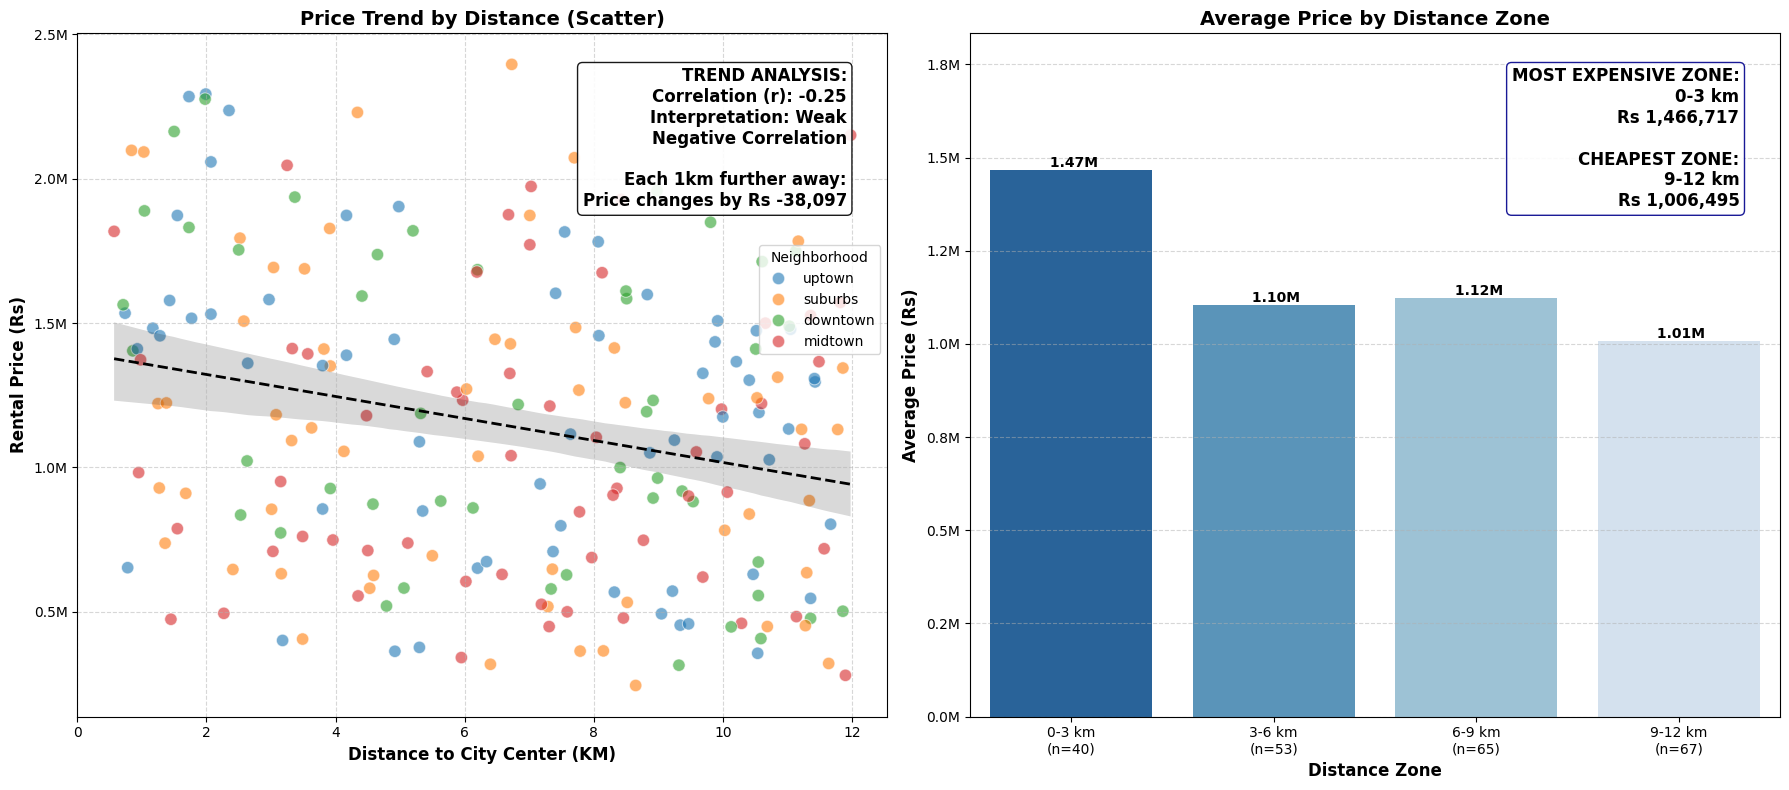

In [39]:
# 2. Prepare Data
# Create Distance Bins for the second chart
# Let's see the range first to define bins meaningfully.
min_dist = df_clean['Distance_to_City_Center_KM'].min()
max_dist = df_clean['Distance_to_City_Center_KM'].max()

# Define bins (e.g., 2km intervals)
bins = [0, 3, 6, 9, 12, 15] 
labels = ['0-3 km', '3-6 km', '6-9 km', '9-12 km', '12-15 km']
# Adjust bins if max_dist > 15
if max_dist > 15:
    bins.append(max_dist + 1)
    labels.append(f'15-{int(max_dist)+1} km')

df_clean['Distance_Category'] = pd.cut(df_clean['Distance_to_City_Center_KM'], bins=bins, labels=labels)

# Stats for Bar Chart
dist_stats = df_clean.groupby('Distance_Category')['Rental_Price_Rs'].agg(['mean', 'count']).dropna()
dist_stats['label'] = dist_stats.index.astype(str) + '\n(n=' + dist_stats['count'].astype(str) + ')'


# 3. Create Subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# --- PLOT 1: Scatter Trend (Distance vs Price) ---
sns.scatterplot(
    data=df_clean,
    x='Distance_to_City_Center_KM',
    y='Rental_Price_Rs',
    hue='Neighborhood', # Color by neighborhood adds context
    alpha=0.6,
    s=80,
    ax=axes[0]
)

# Add Regression Line (Global)
sns.regplot(
    data=df_clean,
    x='Distance_to_City_Center_KM',
    y='Rental_Price_Rs',
    scatter=False,
    line_kws={'color': 'black', 'linewidth': 2, 'linestyle': '--'},
    ax=axes[0]
)

# Stats Box (Correlation)
slope, intercept, r_value, p_value, std_err = stats.linregress(df_clean['Distance_to_City_Center_KM'], df_clean['Rental_Price_Rs'])

text_corr = (
    f"TREND ANALYSIS:\n"
    f"Correlation (r): {r_value:.2f}\n"
    f"Interpretation: {'Strong' if abs(r_value) > 0.7 else 'Moderate' if abs(r_value) > 0.4 else 'Weak'}\n"
    f"{'Negative' if r_value < 0 else 'Positive'} Correlation\n\n"
    f"Each 1km further away:\nPrice changes by Rs {slope:,.0f}"
)

axes[0].text(
    0.95, 0.95, text_corr, transform=axes[0].transAxes,
    fontsize=12, verticalalignment='top', horizontalalignment='right', weight='bold',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black')
)

# Formatting Plot 1
axes[0].set_title('Price Trend by Distance (Scatter)', fontsize=14, weight='bold')
axes[0].set_xlabel('Distance to City Center (KM)', fontsize=12, weight='bold')
axes[0].set_ylabel('Rental Price (Rs)', fontsize=12, weight='bold')
axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000000:.1f}M'))
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend(title='Neighborhood', loc='upper right', bbox_to_anchor=(1, 0.7)) # Move legend out of the way


# --- PLOT 2: Average Price by Distance Zone (Bar Chart) ---
sns.barplot(
    x=dist_stats['label'],
    y=dist_stats['mean'],
    palette='Blues_r', # Dark blue to light blue (closer = generally more expensive?)
    ax=axes[1]
)

# Stats Box (Highest vs Lowest Zone)
highest_zone = dist_stats.loc[dist_stats['mean'].idxmax()]
lowest_zone = dist_stats.loc[dist_stats['mean'].idxmin()]

text_zones = (
    f"MOST EXPENSIVE ZONE:\n{highest_zone.name}\nRs {highest_zone['mean']:,.0f}\n\n"
    f"CHEAPEST ZONE:\n{lowest_zone.name}\nRs {lowest_zone['mean']:,.0f}"
)

# Place box in top-right (or left if curve goes down)
axes[1].text(
    0.95, 0.95, text_zones, transform=axes[1].transAxes,
    fontsize=12, verticalalignment='top', horizontalalignment='right', weight='bold',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='darkblue')
)

# Formatting Plot 2
axes[1].set_title('Average Price by Distance Zone', fontsize=14, weight='bold')
axes[1].set_xlabel('Distance Zone', fontsize=12, weight='bold')
axes[1].set_ylabel('Average Price (Rs)', fontsize=12, weight='bold')
axes[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000000:.1f}M'))
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels
for i, v in enumerate(dist_stats['mean']):
    axes[1].text(i, v, f" {v/1000000:.2f}M", ha='center', va='bottom', fontweight='bold')

axes[1].set_ylim(0, dist_stats['mean'].max() * 1.25) # Headroom

plt.tight_layout()
plt.savefig('price_distance_trend.png')
plt.show()

<h2>Correlations & Patterns</h2>
<h3>a.</h3>

C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\3292496051.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


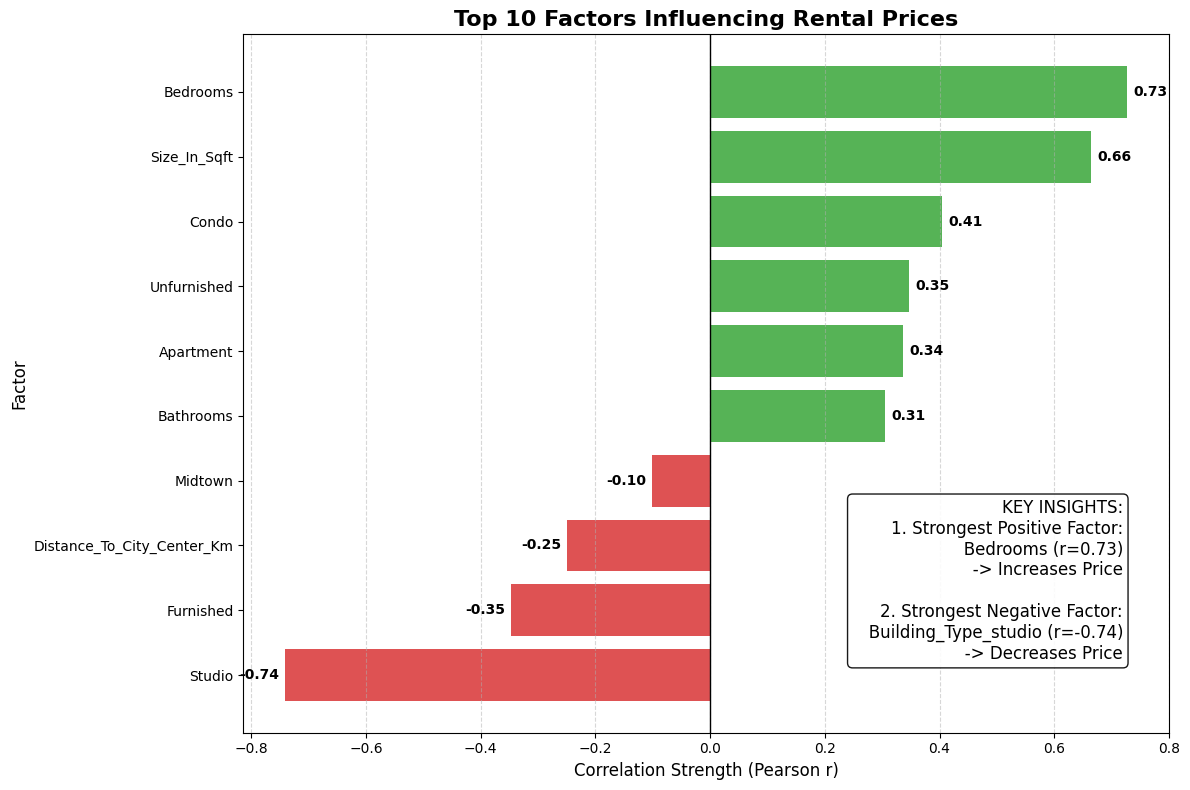

Building_Type_studio         -0.740494
Furnished_furnished          -0.347408
Distance_to_City_Center_KM   -0.248722
Neighborhood_midtown         -0.101783
Bathrooms                     0.305157
Building_Type_apartment       0.336506
Furnished_unfurnished         0.347408
Building_Type_condo           0.405007
Size_in_Sqft                  0.664792
Bedrooms                      0.727224
Name: Rental_Price_Rs, dtype: float64


In [40]:
# 2. Prepare Data for Correlation Analysis
# Select potential features
features = ['Size_in_Sqft', 'Bedrooms', 'Bathrooms', 'Distance_to_City_Center_KM', 
            'Neighborhood', 'Furnished', 'Building_Type']
target = 'Rental_Price_Rs'

# One-Hot Encode Categorical Variables to measure their impact
df_encoded = pd.get_dummies(df_clean[features + [target]], columns=['Neighborhood', 'Furnished', 'Building_Type'], drop_first=False)

# Calculate Correlation with Target
correlations = df_encoded.corr()[target].drop(target) # Drop target itself

# Sort by absolute strength to find "Strongest" factors
# We want to see both positive (increases price) and negative (decreases price)
top_factors = correlations.abs().sort_values(ascending=False).head(10)
top_factors_original = correlations.loc[top_factors.index] # Get original values (+/-)
top_factors_original = top_factors_original.sort_values(ascending=True) # Sort for plotting

# 3. Create Plot (Diverging Bar Chart)
fig, ax = plt.subplots(figsize=(12, 8))

# Create colors based on value (Green for positive, Red for negative)
colors = ['#d62728' if x < 0 else '#2ca02c' for x in top_factors_original]

bars = ax.barh(top_factors_original.index, top_factors_original.values, color=colors, alpha=0.8)

# 4. Add Stats/Labels
# Add value labels to bars
for bar in bars:
    width = bar.get_width()
    label_x_pos = width if width > 0 else width
    align = 'left' if width > 0 else 'right'
    offset = 0.01 if width > 0 else -0.01
    
    ax.text(
        label_x_pos + offset, 
        bar.get_y() + bar.get_height()/2, 
        f"{width:.2f}", 
        va='center', ha=align, fontweight='bold', color='black'
    )

# Stats Box (Interpretation)
strongest_pos = top_factors_original[top_factors_original > 0].idxmax() if (top_factors_original > 0).any() else "None"
strongest_pos_val = top_factors_original.max() if (top_factors_original > 0).any() else 0

strongest_neg = top_factors_original[top_factors_original < 0].idxmin() if (top_factors_original < 0).any() else "None"
strongest_neg_val = top_factors_original.min() if (top_factors_original < 0).any() else 0

text_stats = (
    f"KEY INSIGHTS:\n"
    f"1. Strongest Positive Factor:\n   {strongest_pos} (r={strongest_pos_val:.2f})\n   -> Increases Price\n\n"
    f"2. Strongest Negative Factor:\n   {strongest_neg} (r={strongest_neg_val:.2f})\n   -> Decreases Price"
)

# Place box in a corner (Bottom Right usually empty for horizontal bars)
ax.text(
    0.95, 0.1, text_stats, transform=ax.transAxes,
    fontsize=12, verticalalignment='bottom', horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black')
)

# 5. Formatting
ax.set_title('Top 10 Factors Influencing Rental Prices', fontsize=16, weight='bold')
ax.set_xlabel('Correlation Strength (Pearson r)', fontsize=12)
ax.set_ylabel('Factor', fontsize=12)
ax.axvline(0, color='black', linewidth=1) # Zero line
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Clean up y-axis labels (remove prefixes like "Neighborhood_")
new_labels = [label.replace('Neighborhood_', '').replace('Building_Type_', '').replace('Furnished_', '') for label in top_factors_original.index]
new_labels = [label.title() for label in new_labels]
ax.set_yticklabels(new_labels)

plt.tight_layout()
plt.savefig('rental_price_factors.png')
plt.show()

print(top_factors_original)

<h2>b.</h2>

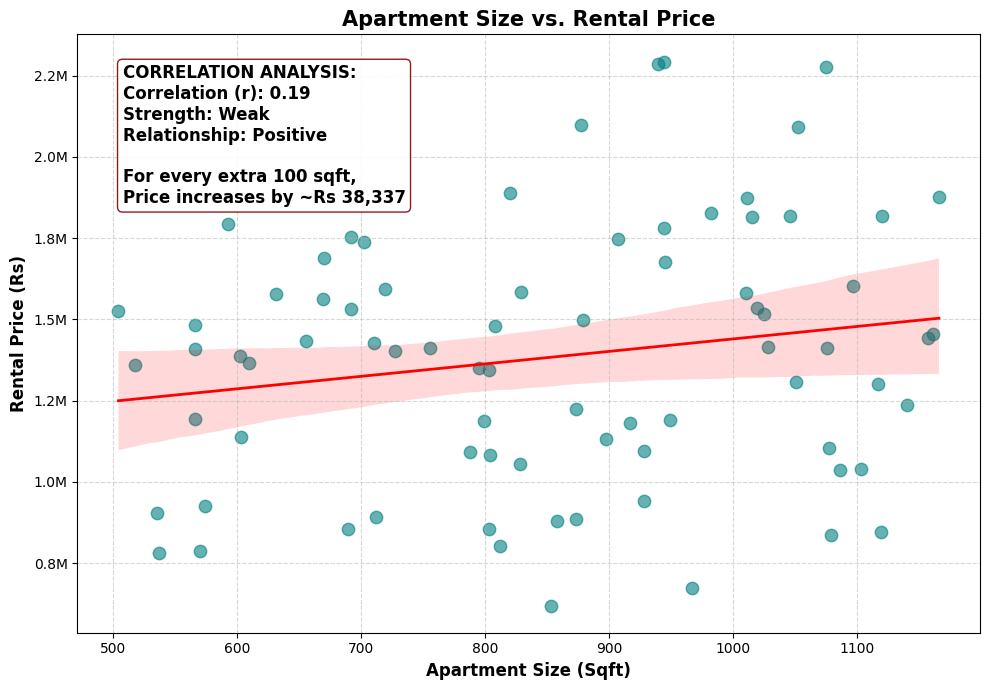

Correlation: 0.18557911303292793


In [41]:
# 3. Calculate Correlation
r_value = df_apartment['Size_in_Sqft'].corr(df_apartment['Rental_Price_Rs'])
slope, intercept, r_val_reg, p_val, std_err = stats.linregress(df_apartment['Size_in_Sqft'], df_apartment['Rental_Price_Rs'])

# 4. Create Plot
fig, ax = plt.subplots(figsize=(10, 7))

# Scatter plot with regression line
sns.regplot(
    data=df_apartment,
    x='Size_in_Sqft',
    y='Rental_Price_Rs',
    scatter_kws={'alpha': 0.6, 's': 80, 'color': 'teal'},
    line_kws={'color': 'red', 'linewidth': 2},
    ax=ax
)

# 5. Add Stats Box
text_stats = (
    f"CORRELATION ANALYSIS:\n"
    f"Correlation (r): {r_value:.2f}\n"
    f"Strength: {'Strong' if abs(r_value) > 0.7 else 'Moderate' if abs(r_value) > 0.4 else 'Weak'}\n"
    f"Relationship: Positive\n\n"
    f"For every extra 100 sqft,\nPrice increases by ~Rs {slope*100:,.0f}"
)

ax.text(
    0.05, 0.95, text_stats, transform=ax.transAxes,
    fontsize=12, verticalalignment='top', weight='bold',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='darkred')
)

# 6. Formatting
ax.set_title('Apartment Size vs. Rental Price', fontsize=15, weight='bold')
ax.set_xlabel('Apartment Size (Sqft)', fontsize=12, weight='bold')
ax.set_ylabel('Rental Price (Rs)', fontsize=12, weight='bold')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000000:.1f}M'))
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('apartment_size_price_corr.png')
plt.show()

print(f"Correlation: {r_value}")

<h2>c.</h2>

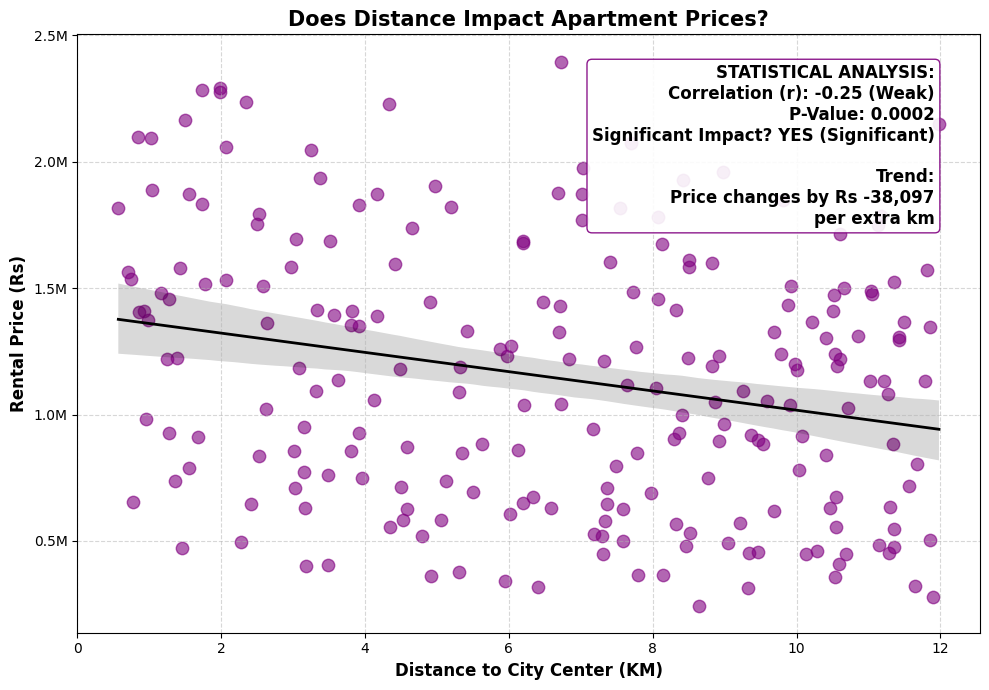

P-value: 0.00016360394784055278


In [42]:
# 2. Calculate Stats (Correlation & P-value)
slope, intercept, r_value, p_value, std_err = stats.linregress(df_clean['Distance_to_City_Center_KM'], df_clean['Rental_Price_Rs'])

# 3. Create Plot
fig, ax = plt.subplots(figsize=(10, 7))

sns.regplot(
    data=df_clean,
    x='Distance_to_City_Center_KM',
    y='Rental_Price_Rs',
    scatter_kws={'alpha': 0.6, 's': 80, 'color': 'purple'},
    line_kws={'color': 'black', 'linewidth': 2},
    ax=ax
)

# 4. Add Stats Box
significance = "YES (Significant)" if p_value < 0.05 else "NO (Not Significant)"
strength = 'Strong' if abs(r_value) > 0.7 else 'Moderate' if abs(r_value) > 0.4 else 'Weak'

text_stats = (
    f"STATISTICAL ANALYSIS:\n"
    f"Correlation (r): {r_value:.2f} ({strength})\n"
    f"P-Value: {p_value:.4f}\n"
    f"Significant Impact? {significance}\n\n"
    f"Trend:\nPrice changes by Rs {slope:,.0f}\nper extra km"
)

ax.text(
    0.95, 0.95, text_stats, transform=ax.transAxes,
    fontsize=12, verticalalignment='top', horizontalalignment='right', weight='bold',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='purple')
)

# 5. Formatting
ax.set_title('Does Distance Impact Apartment Prices?', fontsize=15, weight='bold')
ax.set_xlabel('Distance to City Center (KM)', fontsize=12, weight='bold')
ax.set_ylabel('Rental Price (Rs)', fontsize=12, weight='bold')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000000:.1f}M'))
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('apartment_distance_significance.png')
plt.show()

print(f"P-value: {p_value}")

-----------------------------------------------

In [43]:
df_apartment

Apartment_ID  Size_in_Sqft  Bedrooms  Bathrooms  \
0               1           692         1          2   
4               5          1097         3          2   
6               7           592         1          1   
7               8           897         1          1   
8               9           799         1          1   
..            ...           ...       ...        ...   
233           232           939         3          1   
234           233           928         1          2   
235           234          1103         1          2   
238           237          1119         2          2   
250           249          1052         1          2   

     Distance_to_City_Center_KM Neighborhood    Furnished Building_Type  \
0                          2.07       uptown    furnished     apartment   
4                          7.41       uptown  unfurnished     apartment   
6                          2.52      suburbs  unfurnished     apartment   
7                         11.02       uptown  unfurnished     apartment   
8                          5.32     downtown  unfurnished     apartment   
..                          ...          ...          ...           ...   
233                        1.73       uptown  unfurnished     apartment   
234                        9.25       uptown  unfurnished     apartment   
235                        6.72      midtown  unfurnished     apartment   
238                        7.78      midtown    furnished     apartment   
250                        1.03      suburbs  unfurnished     apartment   

     Rental_Price  Rental_Price_Rs  Bedrooms_Jittered             label  
0     5035.497680     1.530791e+06           0.949816    uptown\n(n=30)  
4     5272.940908     1.602974e+06           2.862407    uptown\n(n=30)  
6     5901.029902     1.793913e+06           0.823233   suburbs\n(n=19)  
7     3727.392455     1.133127e+06           1.146470    uptown\n(n=30)  
8     3904.539655     1.186980e+06           1.040446  downtown\n(n=15)  
..            ...              ...                ...               ...  
233   7514.199952     2.284317e+06           3.001055    uptown\n(n=30)  
234   3599.883656     1.094365e+06           1.030762    uptown\n(n=30)  
235   3422.884419     1.040557e+06           0.997007   midtown\n(n=14)  
238   2782.907171     8.460038e+05           1.912309   midtown\n(n=14)  
250   6883.107093     2.092465e+06           1.185448   suburbs\n(n=19)  

[78 rows x 12 columns]

In [44]:
df_clean

Apartment_ID  Size_in_Sqft  Bedrooms  Bathrooms  \
0               1           692         1          2   
1               2           622         3          1   
2               3           559         0          1   
3               4           307         0          1   
4               5          1097         3          2   
..            ...           ...       ...        ...   
247           246           482         0          1   
248           247           807         1          1   
249           248          1235         1          2   
250           249          1052         1          2   
251           250           683         2          1   

     Distance_to_City_Center_KM Neighborhood    Furnished Building_Type  \
0                          2.07       uptown    furnished     apartment   
1                         10.85      suburbs  unfurnished         condo   
2                         10.55     downtown    furnished        studio   
3                          7.37       uptown    furnished        studio   
4                          7.41       uptown  unfurnished     apartment   
..                          ...          ...          ...           ...   
247                        7.19      midtown    furnished        studio   
248                        4.48      midtown    furnished         condo   
249                        7.64       uptown    furnished         condo   
250                        1.03      suburbs  unfurnished     apartment   
251                       10.52       uptown    furnished         condo   

     Rental_Price  Rental_Price_Rs  Bedrooms_Jittered             label  \
0     5035.497680     1.530791e+06           0.949816    uptown\n(n=62)   
1     4316.686202     1.312273e+06           3.180286   suburbs\n(n=58)   
2     2211.047997     6.721586e+05           0.092798  downtown\n(n=47)   
3     2330.542651     7.084850e+05           0.039463    uptown\n(n=62)   
4     5272.940908     1.602974e+06           2.862407    uptown\n(n=62)   
..            ...              ...                ...               ...   
247   1729.501548     5.257685e+05           0.171327   midtown\n(n=58)   
248   3878.499944     1.179064e+06           0.971274   midtown\n(n=58)   
249   3668.000968     1.115072e+06           1.186662    uptown\n(n=62)   
250   6883.107093     2.092465e+06           1.185448   suburbs\n(n=58)   
251   4846.892203     1.473455e+06           2.141204    uptown\n(n=62)   

    Distance_Category  
0              0-3 km  
1             9-12 km  
2             9-12 km  
3              6-9 km  
4              6-9 km  
..                ...  
247            6-9 km  
248            3-6 km  
249            6-9 km  
250            0-3 km  
251           9-12 km  

[225 rows x 13 columns]

C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\4254181973.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


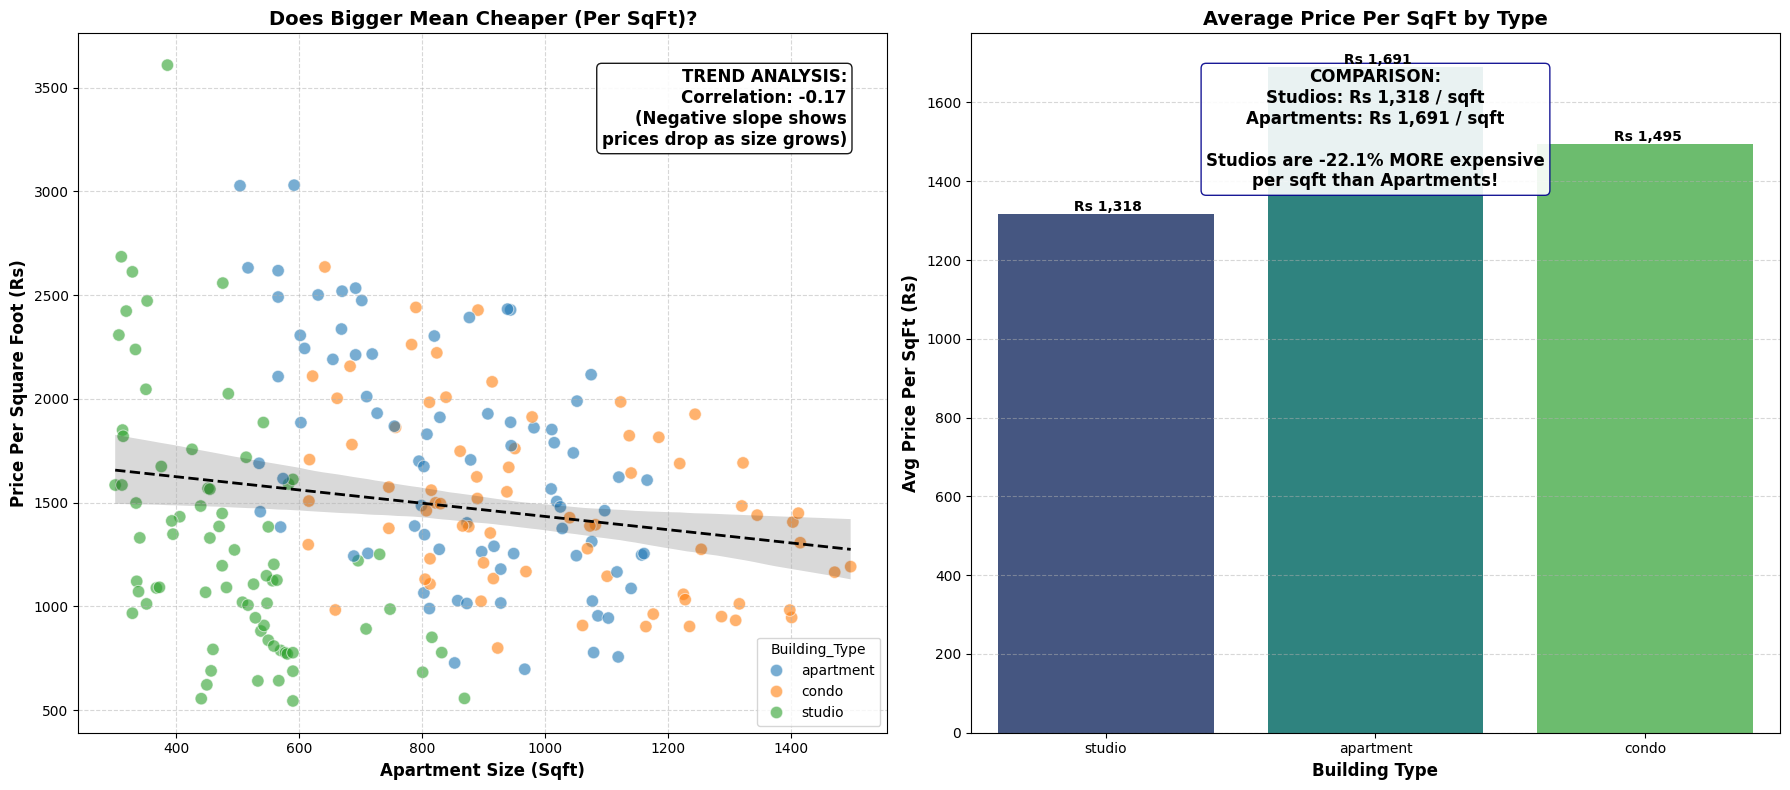

In [46]:
# 2. Calculate Price Per SqFt
df_clean['Price_Per_Sqft'] = df_clean['Rental_Price_Rs'] / df_clean['Size_in_Sqft']

# 3. Create Subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# --- PLOT 1: Scatter (Size vs Price Per SqFt) ---
sns.scatterplot(
    data=df_clean,
    x='Size_in_Sqft',
    y='Price_Per_Sqft',
    hue='Building_Type',
    alpha=0.6,
    s=80,
    ax=axes[0]
)

# Regression Line to show the trend
sns.regplot(
    data=df_clean,
    x='Size_in_Sqft',
    y='Price_Per_Sqft',
    scatter=False,
    line_kws={'color': 'black', 'linewidth': 2, 'linestyle': '--'},
    ax=axes[0]
)

# Stats for Plot 1
slope, intercept, r_value, p_value, std_err = stats.linregress(df_clean['Size_in_Sqft'], df_clean['Price_Per_Sqft'])
text_scatter = (
    f"TREND ANALYSIS:\n"
    f"Correlation: {r_value:.2f}\n"
    f"(Negative slope shows\nprices drop as size grows)"
)
axes[0].text(
    0.95, 0.95, text_scatter, transform=axes[0].transAxes,
    fontsize=12, verticalalignment='top', horizontalalignment='right', weight='bold',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black')
)

# Formatting Plot 1
axes[0].set_title('Does Bigger Mean Cheaper (Per SqFt)?', fontsize=14, weight='bold')
axes[0].set_xlabel('Apartment Size (Sqft)', fontsize=12, weight='bold')
axes[0].set_ylabel('Price Per Square Foot (Rs)', fontsize=12, weight='bold')
axes[0].grid(True, linestyle='--', alpha=0.5)


# --- PLOT 2: Bar Chart (Avg Price Per SqFt by Type) ---
# Order: Studio -> Apartment -> Condo
type_order = ['studio', 'apartment', 'condo']
avg_ppsqft = df_clean.groupby('Building_Type')['Price_Per_Sqft'].mean().reindex(type_order)

sns.barplot(
    x=avg_ppsqft.index,
    y=avg_ppsqft.values,
    palette='viridis',
    ax=axes[1]
)

# Stats for Plot 2
studio_price = avg_ppsqft['studio']
apt_price = avg_ppsqft['apartment']
diff = ((studio_price - apt_price) / apt_price) * 100

text_bar = (
    f"COMPARISON:\n"
    f"Studios: Rs {studio_price:,.0f} / sqft\n"
    f"Apartments: Rs {apt_price:,.0f} / sqft\n\n"
    f"Studios are {diff:.1f}% MORE expensive\nper sqft than Apartments!"
)
axes[1].text(
    0.5, 0.95, text_bar, transform=axes[1].transAxes,
    fontsize=12, verticalalignment='top', horizontalalignment='center', weight='bold',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='darkblue')
)

# Formatting Plot 2
axes[1].set_title('Average Price Per SqFt by Type', fontsize=14, weight='bold')
axes[1].set_xlabel('Building Type', fontsize=12, weight='bold')
axes[1].set_ylabel('Avg Price Per SqFt (Rs)', fontsize=12, weight='bold')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# Labels
for i, v in enumerate(avg_ppsqft.values):
    axes[1].text(i, v, f" Rs {v:,.0f}", ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('hypothesis_price_per_sqft.png')
plt.show()

C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\1653161416.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


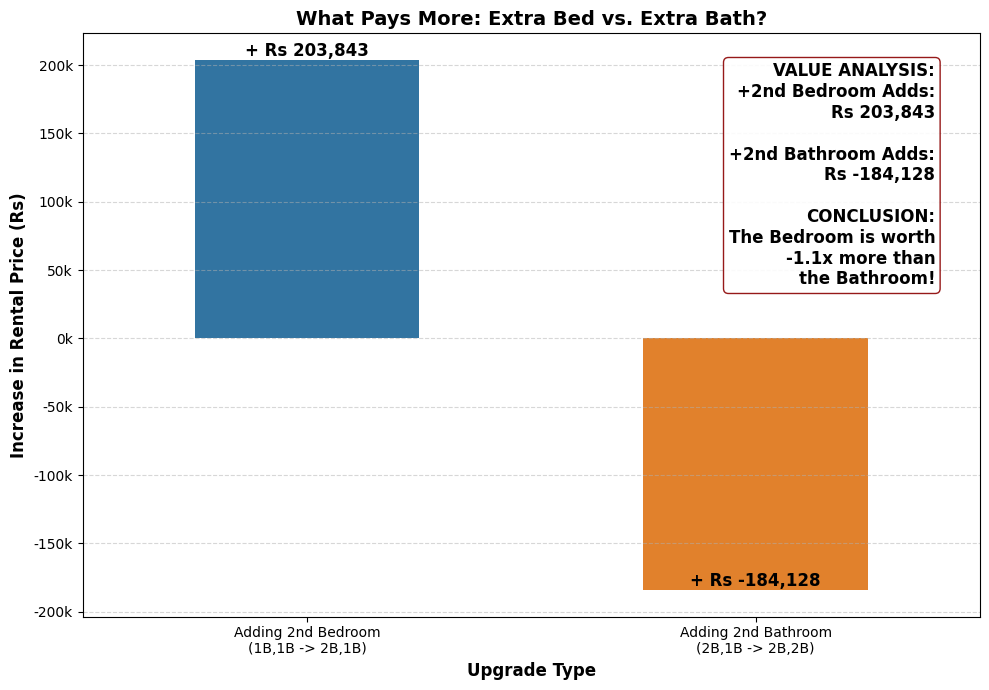

In [47]:
# 2. Define the groups for comparison
# Baseline: 1 Bed, 1 Bath
base_1b1b = df_clean[(df_clean['Bedrooms'] == 1) & (df_clean['Bathrooms'] == 1)]['Rental_Price_Rs'].mean()

# Scenario A: Add a Bedroom (2 Bed, 1 Bath)
bed_upgrade_2b1b = df_clean[(df_clean['Bedrooms'] == 2) & (df_clean['Bathrooms'] == 1)]['Rental_Price_Rs'].mean()

# Scenario B: Add a Bathroom to the 2 Bed (2 Bed, 2 Bath)
bath_upgrade_2b2b = df_clean[(df_clean['Bedrooms'] == 2) & (df_clean['Bathrooms'] == 2)]['Rental_Price_Rs'].mean()

# Calculate Premiums
premium_bedroom = bed_upgrade_2b1b - base_1b1b
premium_bathroom = bath_upgrade_2b2b - bed_upgrade_2b1b

# Prepare Data for Plotting
comparison_data = pd.DataFrame({
    'Upgrade': ['Adding 2nd Bedroom\n(1B,1B -> 2B,1B)', 'Adding 2nd Bathroom\n(2B,1B -> 2B,2B)'],
    'Value_Added': [premium_bedroom, premium_bathroom],
    'Color': ['#1f77b4', '#ff7f0e'] # Blue for Bed, Orange for Bath
})

# 3. Create Plot
fig, ax = plt.subplots(figsize=(10, 7))

sns.barplot(
    data=comparison_data,
    x='Upgrade',
    y='Value_Added',
    palette=comparison_data['Color'].tolist(),
    ax=ax,
    width=0.5
)

# 4. Add Stats Box
text_stats = (
    f"VALUE ANALYSIS:\n"
    f"+2nd Bedroom Adds:\nRs {premium_bedroom:,.0f}\n\n"
    f"+2nd Bathroom Adds:\nRs {premium_bathroom:,.0f}\n\n"
    f"CONCLUSION:\n"
    f"The Bedroom is worth\n{premium_bedroom/premium_bathroom:.1f}x more than\nthe Bathroom!"
)

ax.text(
    0.95, 0.95, text_stats, transform=ax.transAxes,
    fontsize=12, verticalalignment='top', horizontalalignment='right', weight='bold',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='darkred')
)

# 5. Formatting
ax.set_title('What Pays More: Extra Bed vs. Extra Bath?', fontsize=14, weight='bold')
ax.set_ylabel('Increase in Rental Price (Rs)', fontsize=12, weight='bold')
ax.set_xlabel('Upgrade Type', fontsize=12, weight='bold')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}k'))
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Add Labels on bars
for i, v in enumerate(comparison_data['Value_Added']):
    ax.text(i, v, f"+ Rs {v:,.0f}", ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('hypothesis_bed_vs_bath.png')
plt.show()

C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\4211419920.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_rent.index, y=avg_rent.values, palette='Blues_d', ax=axes[0])
C:\Users\laksh\AppData\Local\Temp\ipykernel_15024\4211419920.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_ppsqft.index, y=avg_ppsqft.values, palette='Greens_d', ax=axes[1])


Plot saved.


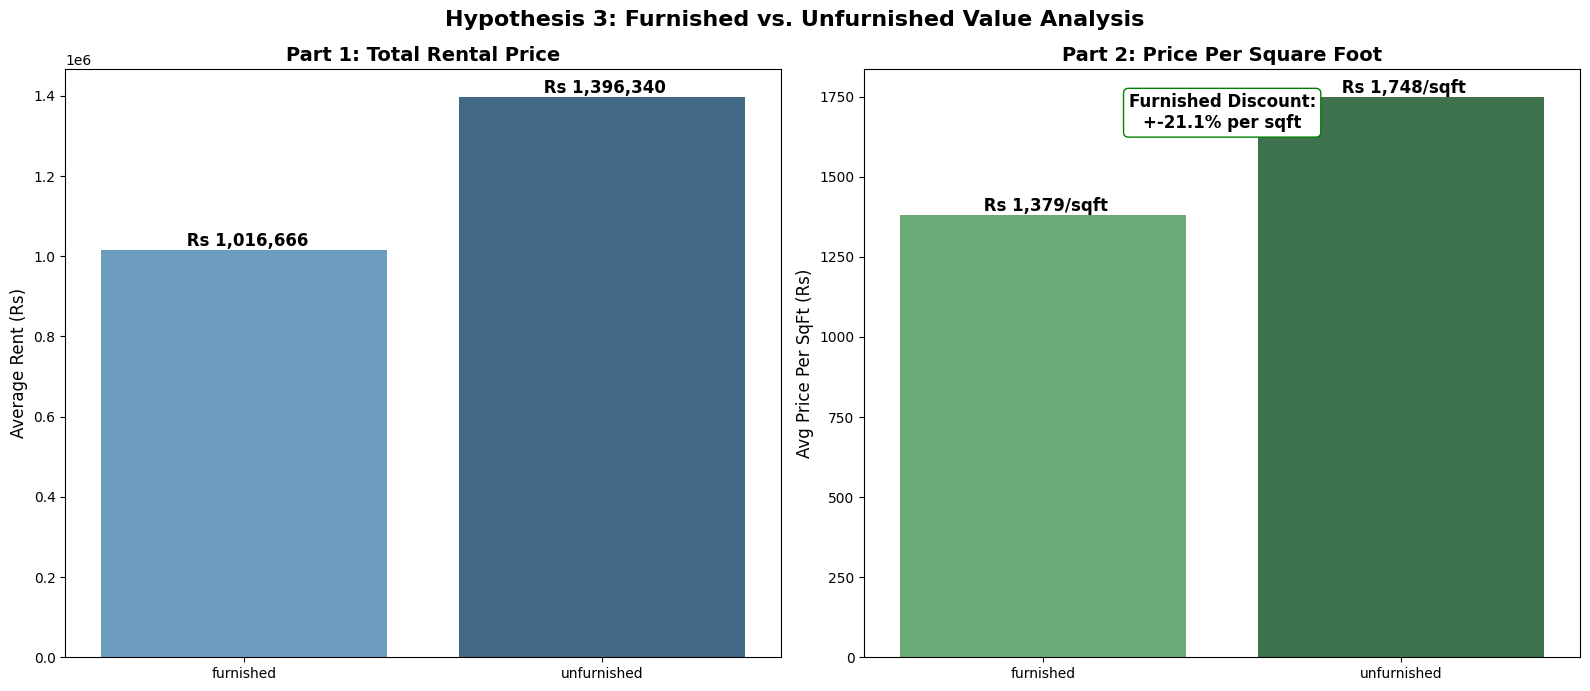

In [49]:
# Calculate Price Per SqFt
df_clean['Price_Per_Sqft'] = df_clean['Rental_Price_Rs'] / df_clean['Size_in_Sqft']

# Set up the figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- PLOT 1: Total Rental Price (Furnished vs Unfurnished) ---
# This checks the first part of your hypothesis
avg_rent = df_clean.groupby('Furnished')['Rental_Price_Rs'].mean()
sns.barplot(x=avg_rent.index, y=avg_rent.values, palette='Blues_d', ax=axes[0])

# Annotations for Plot 1
for i, v in enumerate(avg_rent.values):
    axes[0].text(i, v, f" Rs {v:,.0f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

axes[0].set_title('Part 1: Total Rental Price', fontsize=14, weight='bold')
axes[0].set_ylabel('Average Rent (Rs)', fontsize=12)
axes[0].set_xlabel('')

# --- PLOT 2: Price Per SqFt (Furnished vs Unfurnished) ---
# This checks the second part of your hypothesis (the "Premium")
avg_ppsqft = df_clean.groupby('Furnished')['Price_Per_Sqft'].mean()
sns.barplot(x=avg_ppsqft.index, y=avg_ppsqft.values, palette='Greens_d', ax=axes[1])

# Annotations for Plot 2
for i, v in enumerate(avg_ppsqft.values):
    axes[1].text(i, v, f" Rs {v:,.0f}/sqft", ha='center', va='bottom', fontsize=12, fontweight='bold')

# Calculate the premium percentage
furnished_val = avg_ppsqft.get('furnished', 0)
unfurnished_val = avg_ppsqft.get('unfurnished', 0)
if unfurnished_val > 0:
    diff_pct = ((furnished_val - unfurnished_val) / unfurnished_val) * 100
    text_diff = f"Furnished Discount:\n+{diff_pct:.1f}% per sqft"
    axes[1].text(0.5, 0.9, text_diff, transform=axes[1].transAxes, 
                 ha='center', fontsize=12, weight='bold',
                 bbox=dict(boxstyle='round', facecolor='white', edgecolor='green'))

axes[1].set_title('Part 2: Price Per Square Foot', fontsize=14, weight='bold')
axes[1].set_ylabel('Avg Price Per SqFt (Rs)', fontsize=12)
axes[1].set_xlabel('')

plt.suptitle('Hypothesis 3: Furnished vs. Unfurnished Value Analysis', fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig('hypothesis3_furnished_analysis.png')
print("Plot saved.")

In [121]:
df_clean.to_csv('df_clean.csv', index=False)

---------------------------------------------------------------------------------------------------------------

$$y = wx + b$$
$$Price\:PerFt(P_{sqft}) = \frac{Rental\:Price(R)}{Size\:in\:SqFt(S)}$$
$$r=w\times \frac{\sigma_{x}}{\sigma{y}}$$
$$Precentage\:Difference=(\frac{\bar{x}_{studio}-\bar{x}_{apartment}}{\bar{x}_{apartment}}\times 100)$$
$$=(\frac{1,318-1,691}{1,691})\times100$$
$$\approx-22.1%$$

-----------------------------------------------------------------------------

$$Value\:Added = Average\:Price_{After\:Upgrade} - Average\:Price_{Before\:Upgrade}$$
$$V_{bed} = \bar{P}_{(2Bed,1Bath)- \bar{P}_{(1Bed,1Bath)}}$$
$$V_{bed}=+Rs\:203,843$$
$$V_{bath} = \bar{P}_{(2Bed,2Bath)- \bar{P}_{(2Bed,1Bath)}}$$
$$V_{bath}=-Rs\:184,128$$

$$\Big[Ratio=\frac{V_{bed}{V_{bath}}}=\frac{203,843}{-184,128}\approx-1.1\times]$$

----------------------------------------------------------

$$\Delta_{Rent} = \bar{R}_{Unfurnished}-\bar{R}_{Furnished}$$
$$\Delta_{Rent} = 1,396,340 - 1,016,666$$
$$=Rs\:379,674$$
$$P_{sqft_diff}=\frac{P_{Furnished}-P_{Unfirnished}}{P_{Unfirnished}}\times100$$
$$P_{sqft_diff}=\frac{1,379-1,748}{1,748}\times100$$
$$P_{sqft_diff}\approx-21.1%$$